## Why not MAPE

In this notebook, we investigate MAPE, and show why it's a challenging metric.

In [ ]:
from pathlib import Path

import numpy as np
import scipy as sp
import os
import pandas_gbq
import matplotlib.pyplot as plt

%load_ext google.cloud.bigquery
BQ_PROJECT_ID = "dhh-ncr-stg"

CURRENT_DIR = Path(os.getcwd())
BASE_PLOT_PATH = CURRENT_DIR.parent / "figures" 
BASE_QUERY_PATH = CURRENT_DIR.parent / "queries"
GROUND_TRUTH_SQL_PATH = BASE_QUERY_PATH / "ground_truth.sql"


SEED = 13
rng = np.random.default_rng(SEED)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [7]:
try:
    with open(GROUND_TRUTH_SQL_PATH, 'r') as file:
        sql_query = file.read()
    print(f"Loaded SQL query: {len(sql_query)} characters")
except FileNotFoundError:
    print("SQL file not found")
except IOError:
    print("Error reading the file")

Loaded SQL query: 1000 characters


In [8]:
df = pandas_gbq.read_gbq(sql_query, project_id=BQ_PROJECT_ID)

/Users/patrick.doupe/DH/ad_hoc/error-metrics/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:2660: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [10]:
df.head()

,date_month,management_entity,global_entity_id,vendor_id,campaign_id,booked_budget,cpc_clicks,cpc_orders,cpc_revenue,bid_eur
0,2025-06-01,DH Europe,MJM_AT,cd5a,68405190539c1768bb2b71e4,1000.000000000,402,62,997.799469,2.48
1,2025-06-01,DH Europe,MJM_AT,kgo1,68516ad609163e3aec5ca904,2000.000000000,988,154,1999.406840,2.02
2,2025-06-01,DH Europe,MJM_AT,xopu,6841750204426bf7baf42916,330.000000000,424,141,329.992570,0.78
3,2025-06-01,DH Europe,MJM_AT,o26w,684bf021d7cdc0e4346e8da1,600.000000000,394,54,599.971842,1.52
4,2025-06-01,DH Europe,MJM_AT,bcrf,6850461e4bb2880341a5c18e,500.000000000,443,51,499.918642,1.13


Let's look at clicks. 

We'll take the value as the mean of the Poisson distribution. For example, if we have 402 clicks, the distribution of realised values will be Poisson(402). On average we'll be correct, but we'll be wrong most of the time. This 'wrongness' provides a reasonable lower bound on forecast accuracy (for any measure).

In [55]:
actual_clicks = df.cpc_clicks.values 
sample_realisations = np.array(rng.poisson(actual_clicks))
assert len(actual_clicks) == len(sample_realisations), "The lengths aren't the same, you've messed something up"

i_under_10_actual = np.argwhere(actual_clicks < 10).flatten()
actual_clicks_under_10 = actual_clicks[i_under_10_actual]
sample_actual_under_10 = sample_realisations[i_under_10_actual]

i_over_10_actual = np.argwhere(actual_clicks > 10).flatten()
actual_clicks_over_10 = actual_clicks[i_over_10_actual]
sample_actual_over_10 = sample_realisations[i_over_10_actual]

i_under_100_actual = np.argwhere(actual_clicks < 100).flatten()
actual_clicks_under_100 = actual_clicks[i_under_100_actual]
sample_actual_under_100 = sample_realisations[i_under_100_actual]

i_over_100_actual = np.argwhere(actual_clicks > 100).flatten()
actual_clicks_over_100 = actual_clicks[i_over_100_actual]
sample_actual_over_100 = sample_realisations[i_over_100_actual]

In [56]:
from sklearn.metrics import (mean_absolute_percentage_error,
                             mean_absolute_error,
                             root_mean_squared_error)

In [57]:
# Calculate metrics for all segments
segments = {
    'Overall': (actual_clicks, sample_realisations),
    'Under 10': (actual_clicks_under_10, sample_actual_under_10),
    'Under 100': (actual_clicks_under_100, sample_actual_under_100),
    'Over 100': (actual_clicks_over_100, sample_actual_over_100)
}

results = {}

for segment_name, (actual, predicted) in segments.items():
    # Calculate all metrics
    mape = mean_absolute_percentage_error(actual, predicted)
    rmse = root_mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    
    results[segment_name] = {
        'MAPE': mape * 100,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # Print results
    print(f"\n{segment_name}:")
    print(f"  MAPE: {mape * 100:.2f}%")
    print(f"  RMSE: {rmse:.2f}")
    print(f"   MAE: {mae:.2f}%")




Overall:
  MAPE: 5.56%
  RMSE: 27.00
   MAE: 17.07%

Under 10:
  MAPE: 10.33%
  RMSE: 0.90
   MAE: 0.31%

Under 100:
  MAPE: 11.42%
  RMSE: 5.34
   MAE: 3.10%

Over 100:
  MAPE: 3.74%
  RMSE: 30.80
   MAE: 21.44%


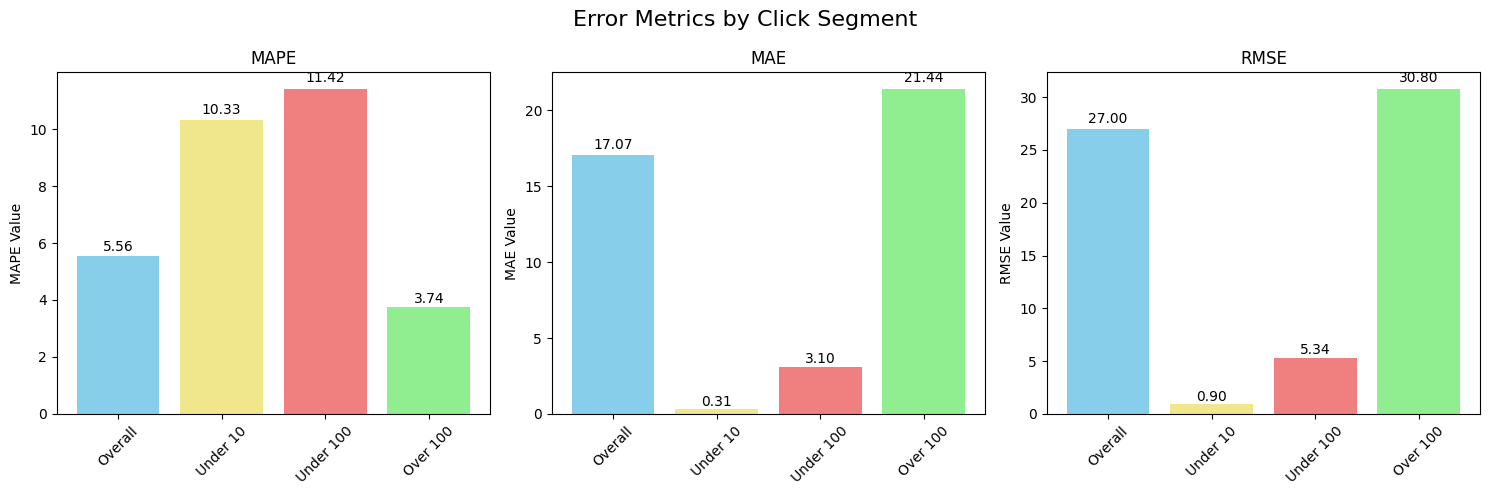

In [62]:
# Create bar chart for specific segments
chart_segments = ['Overall', 'Under 10', 'Under 100', 'Over 100']
metrics = ['MAPE', 'MAE', 'RMSE']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Error Metrics by Click Segment', fontsize=16)

for i, metric in enumerate(metrics):
    values = [results[segment][metric] for segment in chart_segments]
    
    bars = axes[i].bar(chart_segments, values, color=['skyblue', 'khaki', 'lightcoral', 'lightgreen'])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(f'{metric} Value')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
                    f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(BASE_PLOT_PATH / "benchmark_rmse_mape.png", dpi=300, bbox_inches='tight')
plt.show()

Let's do this for each `global_entity_id`


Processing Global Entity ID: MJM_AT
  Overall:
    MAPE: 6.22%
     MAE: 14.18
    RMSE: 19.44
    Data points: 74
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 2
  Under 100:
    MAPE: 11.85%
     MAE: 5.79
    RMSE: 7.78
    Data points: 14
  Over 100:
    MAPE: 4.91%
     MAE: 16.13
    RMSE: 21.26
    Data points: 60


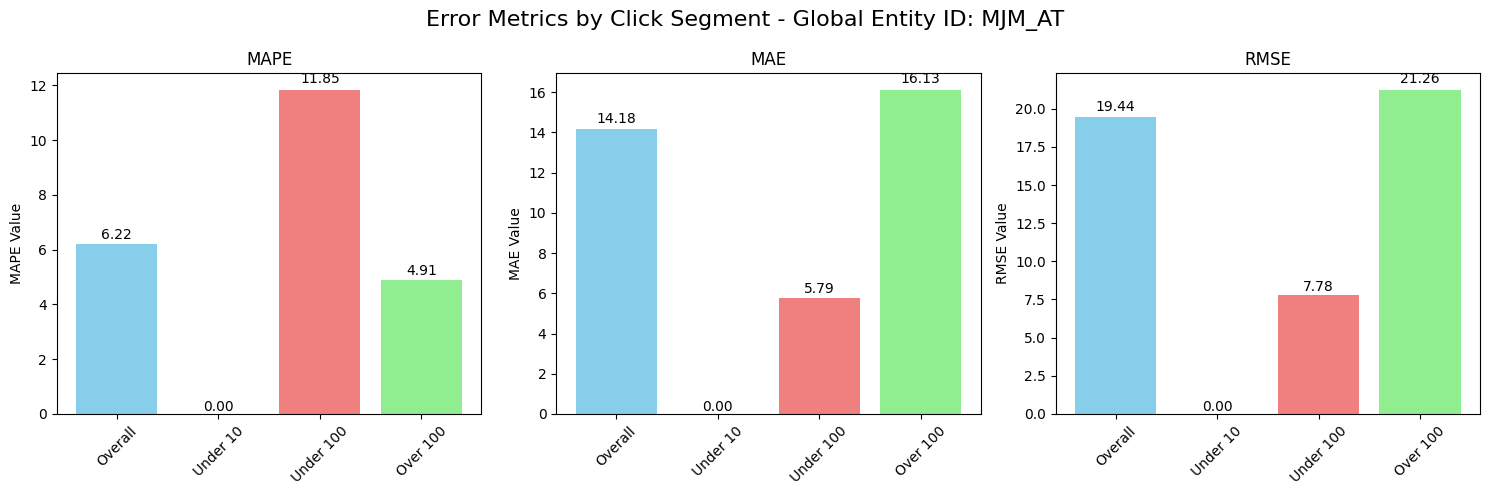

Completed processing for Global Entity ID: MJM_AT

Processing Global Entity ID: DJ_CZ
  Overall:
    MAPE: 5.59%
     MAE: 10.95
    RMSE: 14.94
    Data points: 240
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 2
  Under 100:
    MAPE: 7.40%
     MAE: 4.82
    RMSE: 7.50
    Data points: 34
  Over 100:
    MAPE: 5.29%
     MAE: 11.96
    RMSE: 15.84
    Data points: 206


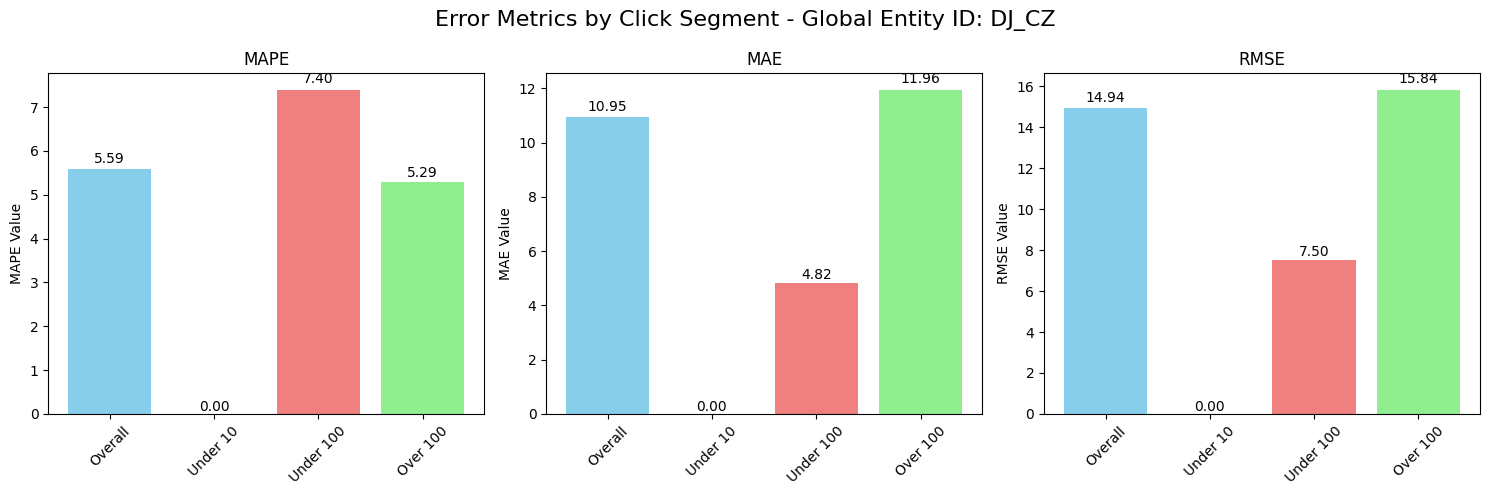

Completed processing for Global Entity ID: DJ_CZ

Processing Global Entity ID: PO_FI
  Overall:
    MAPE: 11.62%
     MAE: 7.41
    RMSE: 11.78
    Data points: 127
  Under 10:
    MAPE: 20.16%
     MAE: 0.88
    RMSE: 1.83
    Data points: 33
  Under 100:
    MAPE: 15.24%
     MAE: 3.53
    RMSE: 5.70
    Data points: 77
  Over 100:
    MAPE: 6.05%
     MAE: 13.38
    RMSE: 17.38
    Data points: 50


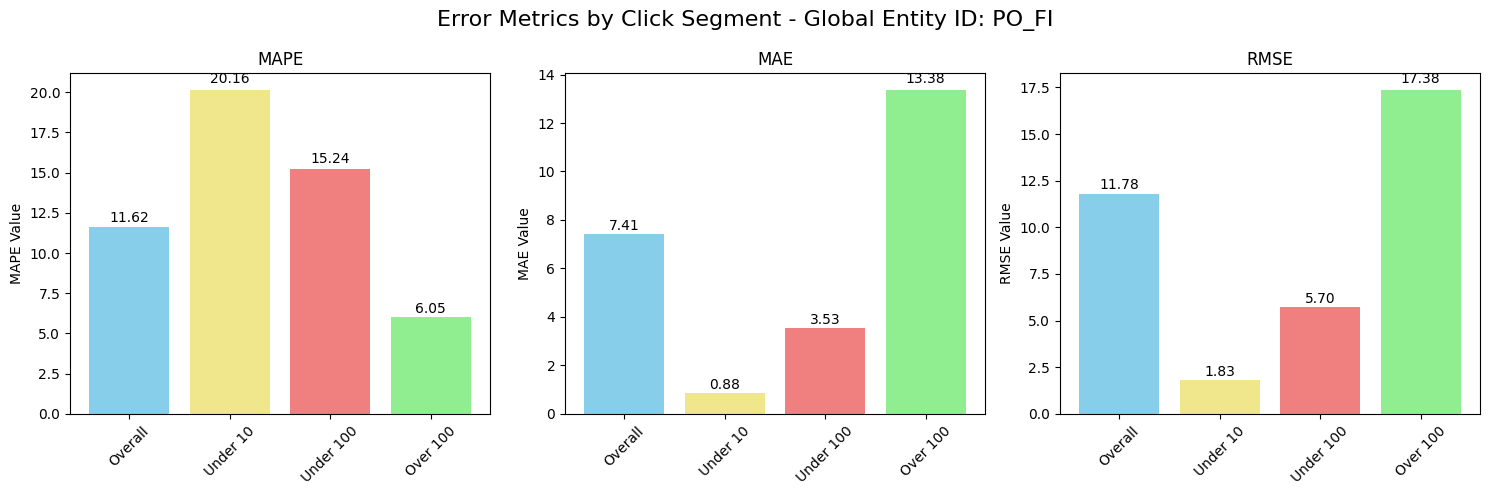

Completed processing for Global Entity ID: PO_FI

Processing Global Entity ID: NP_HU
  Overall:
    MAPE: 5.24%
     MAE: 18.57
    RMSE: 25.96
    Data points: 84
  Under 10:
    MAPE: 16.67%
     MAE: 1.00
    RMSE: 1.73
    Data points: 3
  Under 100:
    MAPE: 18.85%
     MAE: 8.00
    RMSE: 10.80
    Data points: 11
  Over 100:
    MAPE: 3.18%
     MAE: 20.16
    RMSE: 27.53
    Data points: 73


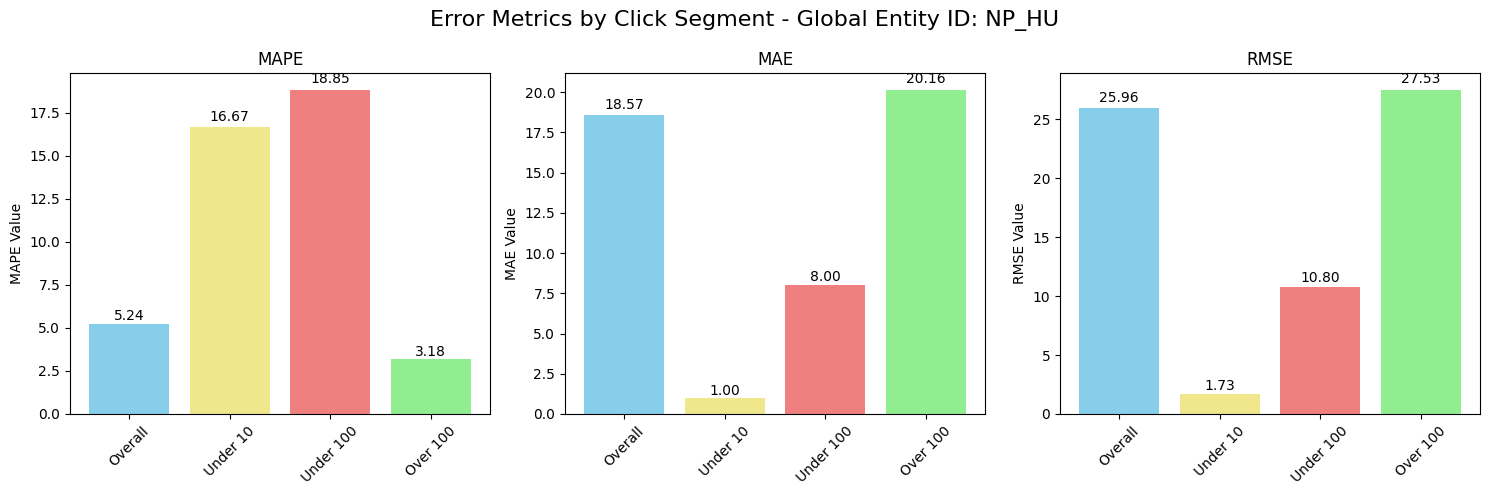

Completed processing for Global Entity ID: NP_HU

Processing Global Entity ID: FO_NO
  Overall:
    MAPE: 7.99%
     MAE: 14.20
    RMSE: 21.87
    Data points: 106
  Under 10:
    MAPE: 9.78%
     MAE: 0.32
    RMSE: 0.83
    Data points: 22
  Under 100:
    MAPE: 13.60%
     MAE: 2.34
    RMSE: 4.62
    Data points: 38
  Over 100:
    MAPE: 4.82%
     MAE: 21.03
    RMSE: 27.28
    Data points: 67


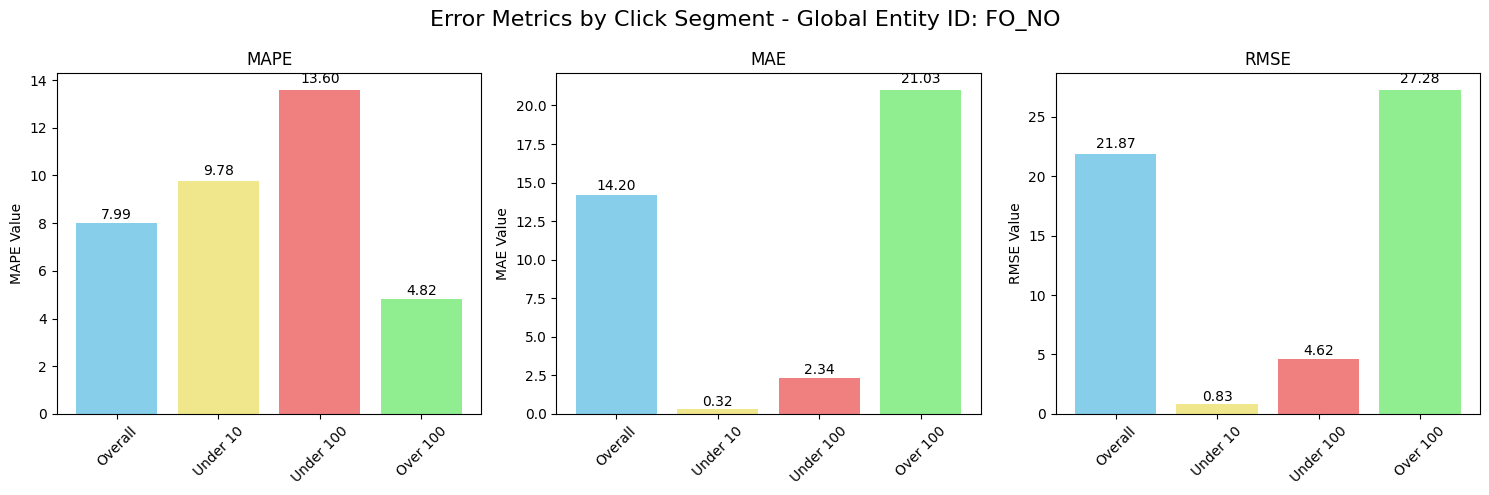

Completed processing for Global Entity ID: FO_NO

Processing Global Entity ID: OP_SE
  Overall:
    MAPE: 5.13%
     MAE: 19.37
    RMSE: 26.51
    Data points: 425
  Under 10:
    MAPE: 40.00%
     MAE: 0.67
    RMSE: 1.15
    Data points: 6
  Under 100:
    MAPE: 17.29%
     MAE: 4.89
    RMSE: 7.08
    Data points: 35
  Over 100:
    MAPE: 4.04%
     MAE: 20.67
    RMSE: 27.59
    Data points: 390


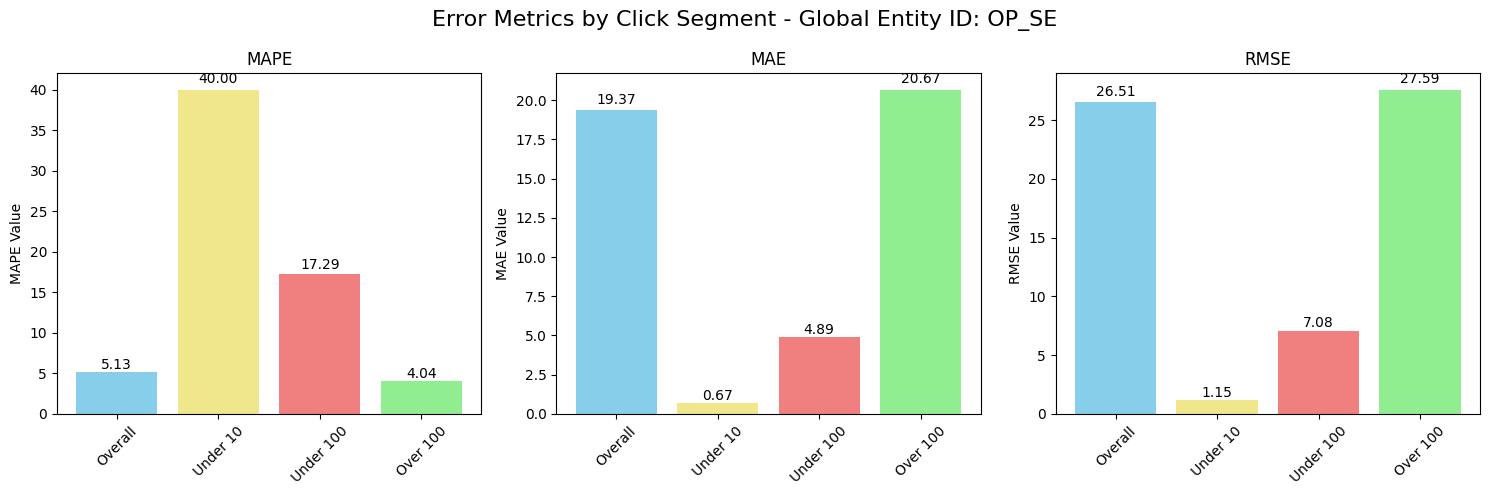

Completed processing for Global Entity ID: OP_SE

Processing Global Entity ID: FP_BD
  Overall:
    MAPE: 7.21%
     MAE: 17.66
    RMSE: 29.78
    Data points: 241
  Under 10:
    MAPE: 23.66%
     MAE: 0.62
    RMSE: 1.12
    Data points: 16
  Under 100:
    MAPE: 15.33%
     MAE: 5.33
    RMSE: 7.54
    Data points: 64
  Over 100:
    MAPE: 4.26%
     MAE: 22.20
    RMSE: 34.54
    Data points: 176


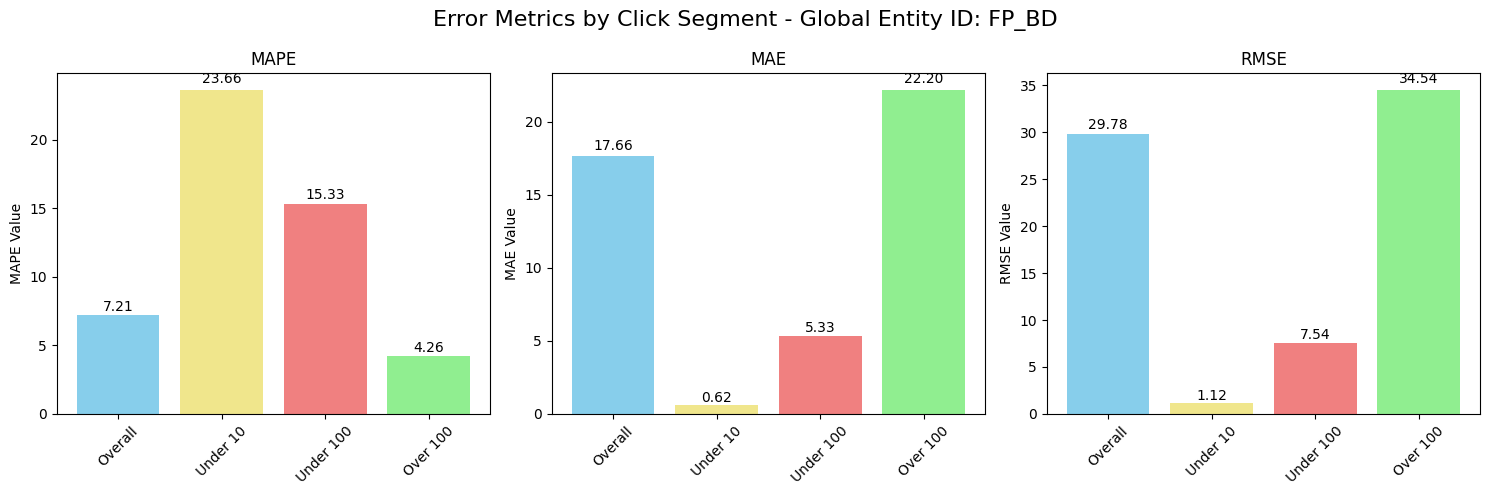

Completed processing for Global Entity ID: FP_BD

Processing Global Entity ID: FP_KH
  Overall:
    MAPE: 10.08%
     MAE: 10.49
    RMSE: 15.16
    Data points: 354
  Under 10:
    MAPE: 27.49%
     MAE: 0.59
    RMSE: 1.06
    Data points: 56
  Under 100:
    MAPE: 19.53%
     MAE: 3.26
    RMSE: 5.17
    Data points: 114
  Over 100:
    MAPE: 5.60%
     MAE: 13.92
    RMSE: 18.07
    Data points: 240


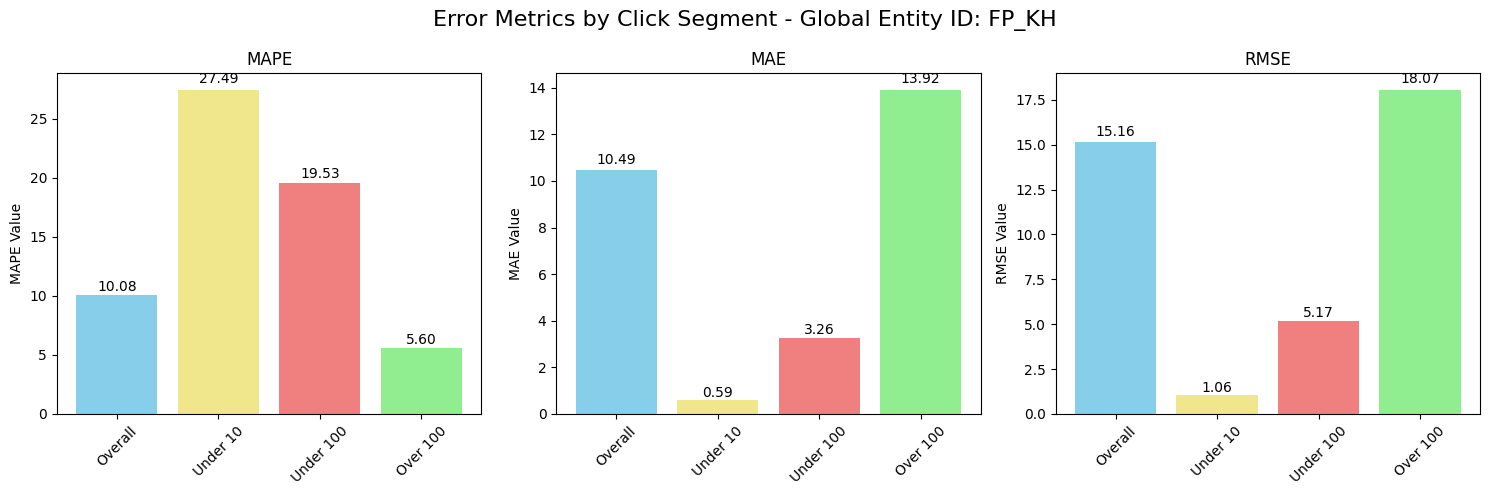

Completed processing for Global Entity ID: FP_KH

Processing Global Entity ID: FP_HK
  Overall:
    MAPE: 4.00%
     MAE: 18.97
    RMSE: 26.40
    Data points: 527
  Under 10:
    MAPE: 9.90%
     MAE: 0.38
    RMSE: 0.61
    Data points: 8
  Under 100:
    MAPE: 9.00%
     MAE: 3.65
    RMSE: 5.78
    Data points: 31
  Over 100:
    MAPE: 3.69%
     MAE: 19.93
    RMSE: 27.18
    Data points: 496


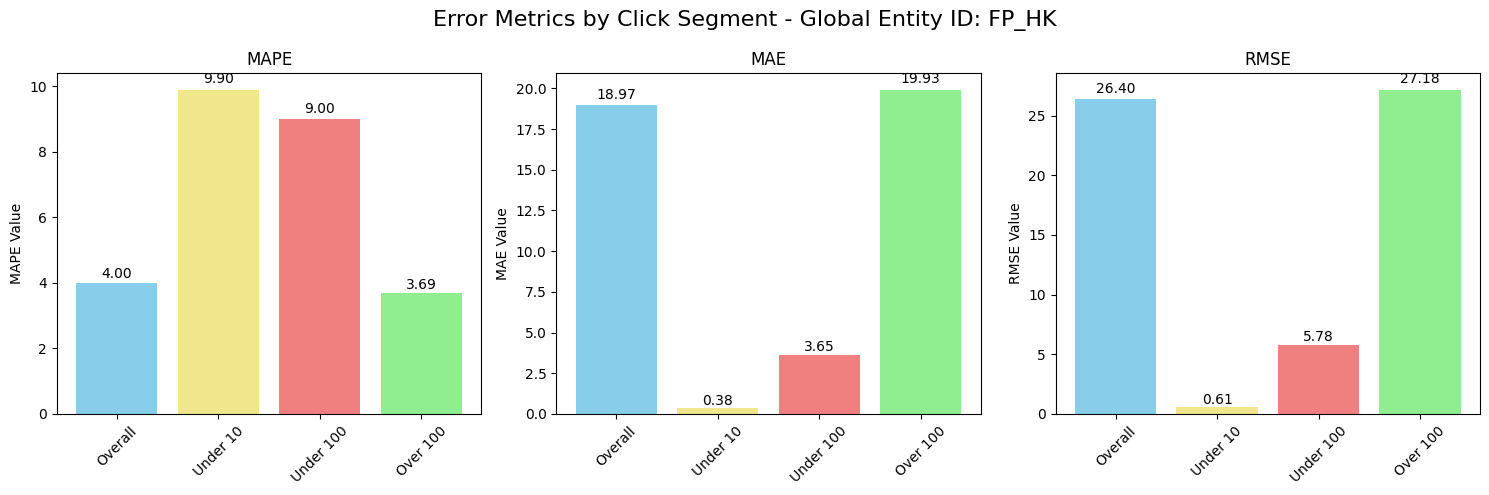

Completed processing for Global Entity ID: FP_HK

Processing Global Entity ID: FP_LA
  Overall:
    MAPE: 5.24%
     MAE: 12.36
    RMSE: 17.68
    Data points: 308
  Under 10:
    MAPE: 2.21%
     MAE: 0.18
    RMSE: 0.73
    Data points: 17
  Under 100:
    MAPE: 7.30%
     MAE: 4.14
    RMSE: 6.21
    Data points: 69
  Over 100:
    MAPE: 4.49%
     MAE: 14.98
    RMSE: 20.07
    Data points: 230


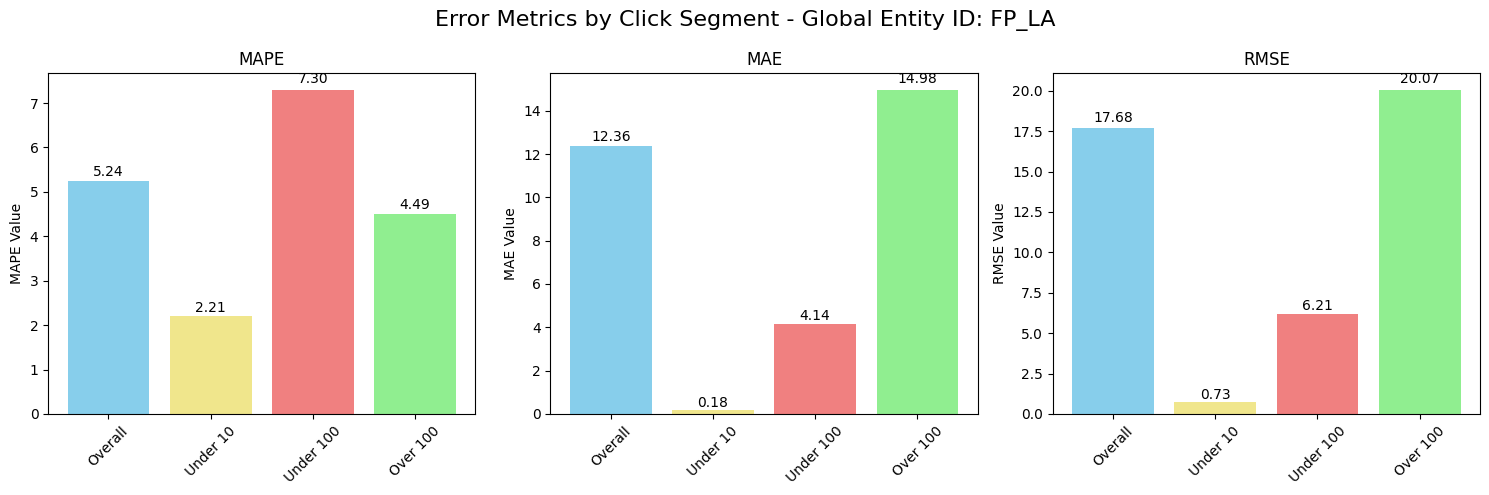

Completed processing for Global Entity ID: FP_LA

Processing Global Entity ID: FP_MY
  Overall:
    MAPE: 4.98%
     MAE: 16.52
    RMSE: 22.84
    Data points: 1054
  Under 10:
    MAPE: 14.57%
     MAE: 0.26
    RMSE: 0.66
    Data points: 43
  Under 100:
    MAPE: 12.28%
     MAE: 3.78
    RMSE: 5.93
    Data points: 138
  Over 100:
    MAPE: 3.88%
     MAE: 18.44
    RMSE: 24.39
    Data points: 916


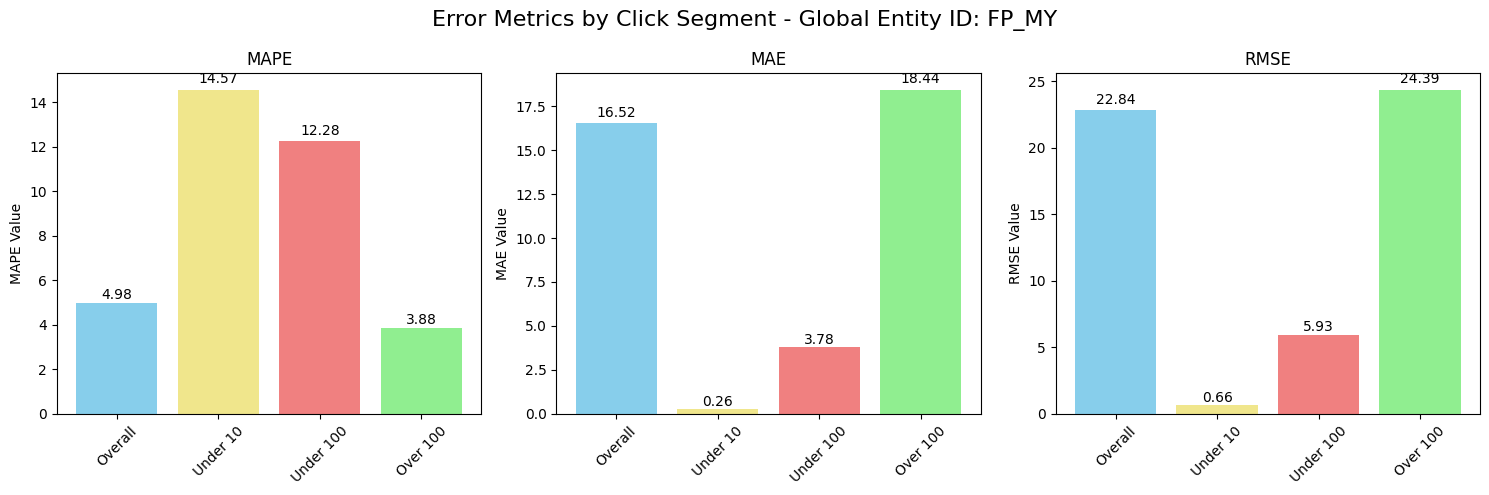

Completed processing for Global Entity ID: FP_MY

Processing Global Entity ID: FP_MM
  Overall:
    MAPE: 3.54%
     MAE: 22.42
    RMSE: 30.86
    Data points: 449
  Under 10:
    MAPE: 9.13%
     MAE: 0.19
    RMSE: 0.44
    Data points: 21
  Under 100:
    MAPE: 9.31%
     MAE: 1.80
    RMSE: 3.26
    Data points: 35
  Over 100:
    MAPE: 3.03%
     MAE: 24.20
    RMSE: 32.15
    Data points: 413


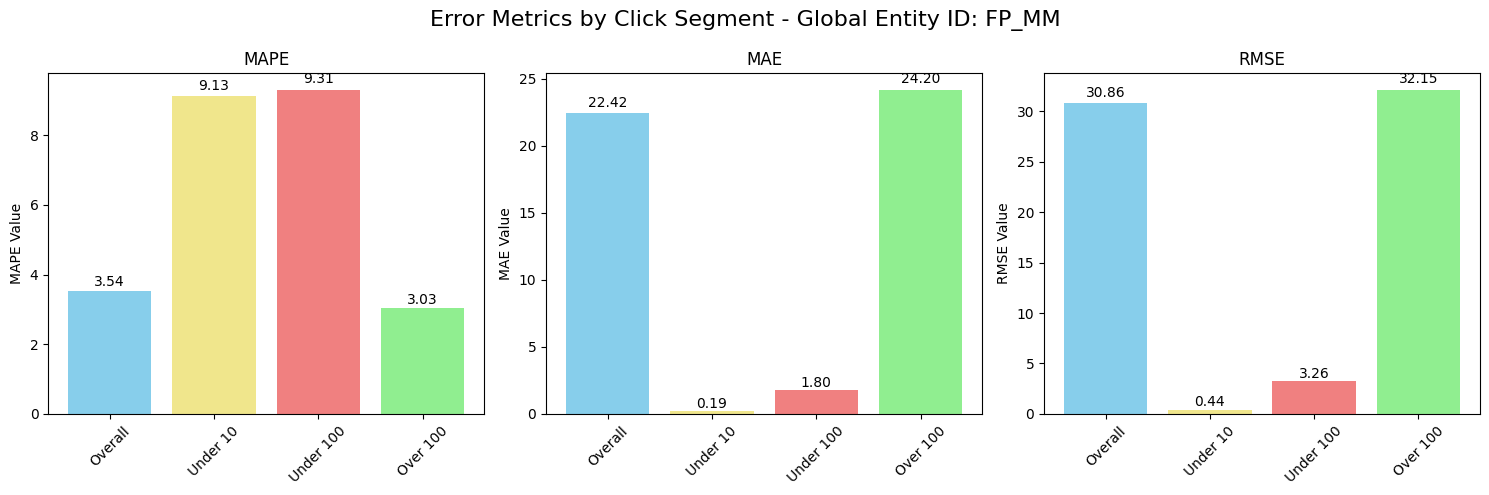

Completed processing for Global Entity ID: FP_MM

Processing Global Entity ID: FP_PK
  Overall:
    MAPE: 6.49%
     MAE: 19.60
    RMSE: 30.24
    Data points: 1449
  Under 10:
    MAPE: 19.73%
     MAE: 0.67
    RMSE: 1.34
    Data points: 124
  Under 100:
    MAPE: 15.31%
     MAE: 3.76
    RMSE: 5.60
    Data points: 381
  Over 100:
    MAPE: 3.31%
     MAE: 25.47
    RMSE: 35.27
    Data points: 1055


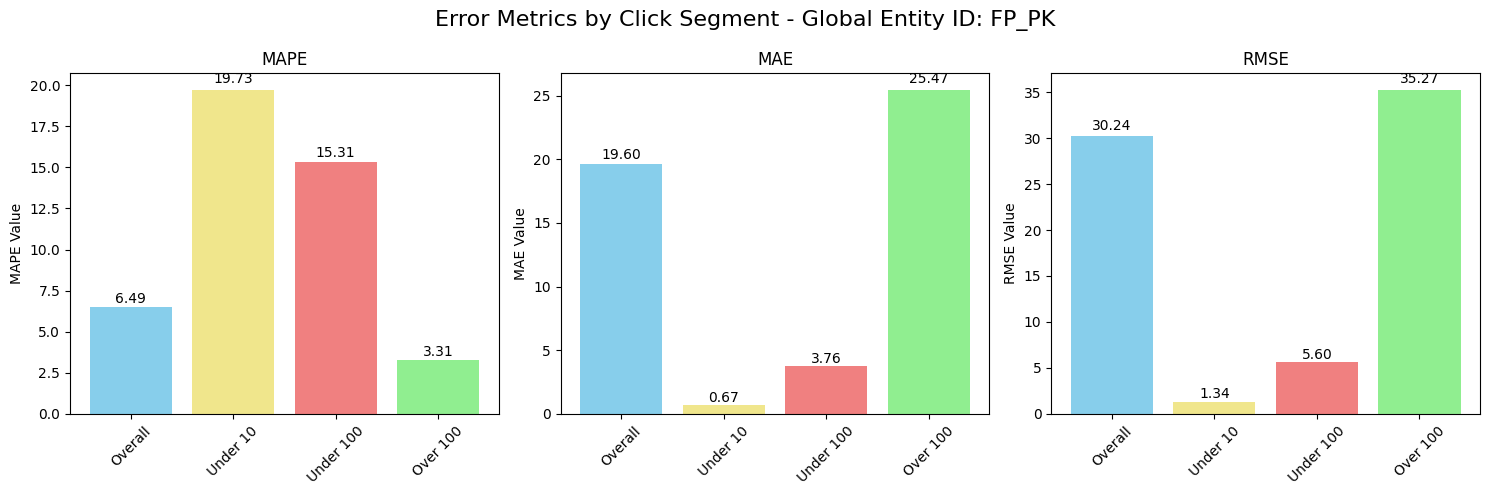

Completed processing for Global Entity ID: FP_PK

Processing Global Entity ID: FP_PH
  Overall:
    MAPE: 4.69%
     MAE: 21.93
    RMSE: 31.35
    Data points: 4281
  Under 10:
    MAPE: 27.85%
     MAE: 0.91
    RMSE: 1.60
    Data points: 148
  Under 100:
    MAPE: 18.83%
     MAE: 3.58
    RMSE: 5.24
    Data points: 394
  Over 100:
    MAPE: 3.22%
     MAE: 23.92
    RMSE: 32.98
    Data points: 3856


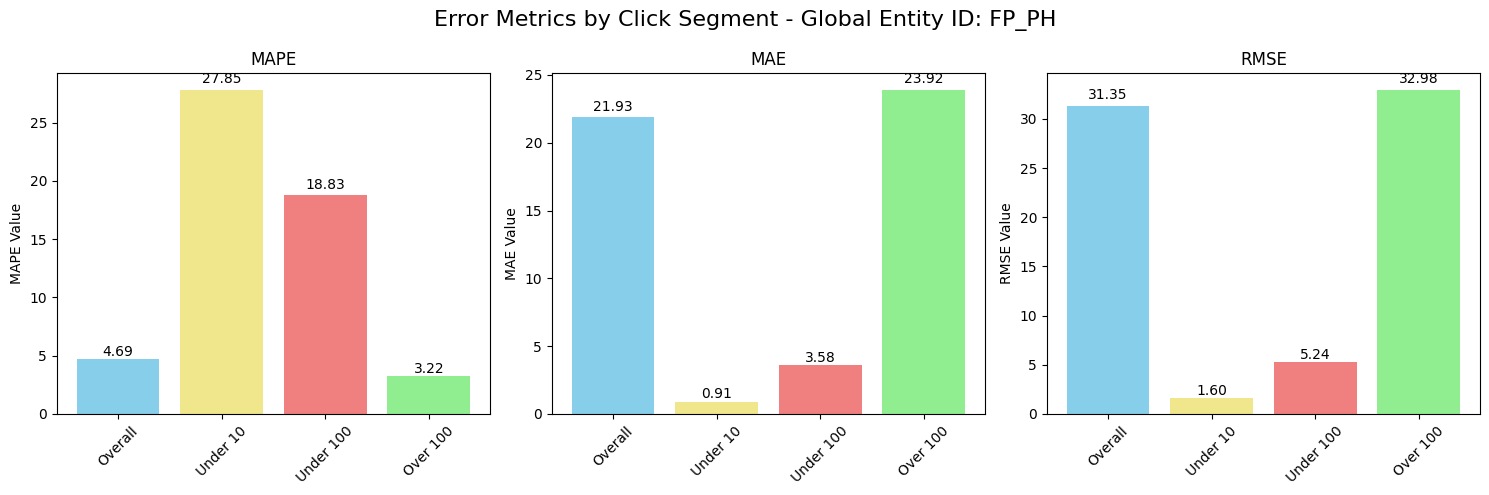

Completed processing for Global Entity ID: FP_PH

Processing Global Entity ID: FP_SG
  Overall:
    MAPE: 7.73%
     MAE: 9.13
    RMSE: 12.67
    Data points: 341
  Under 10:
    MAPE: 13.00%
     MAE: 0.20
    RMSE: 0.60
    Data points: 25
  Under 100:
    MAPE: 10.82%
     MAE: 4.71
    RMSE: 6.56
    Data points: 151
  Over 100:
    MAPE: 5.28%
     MAE: 12.65
    RMSE: 15.94
    Data points: 190


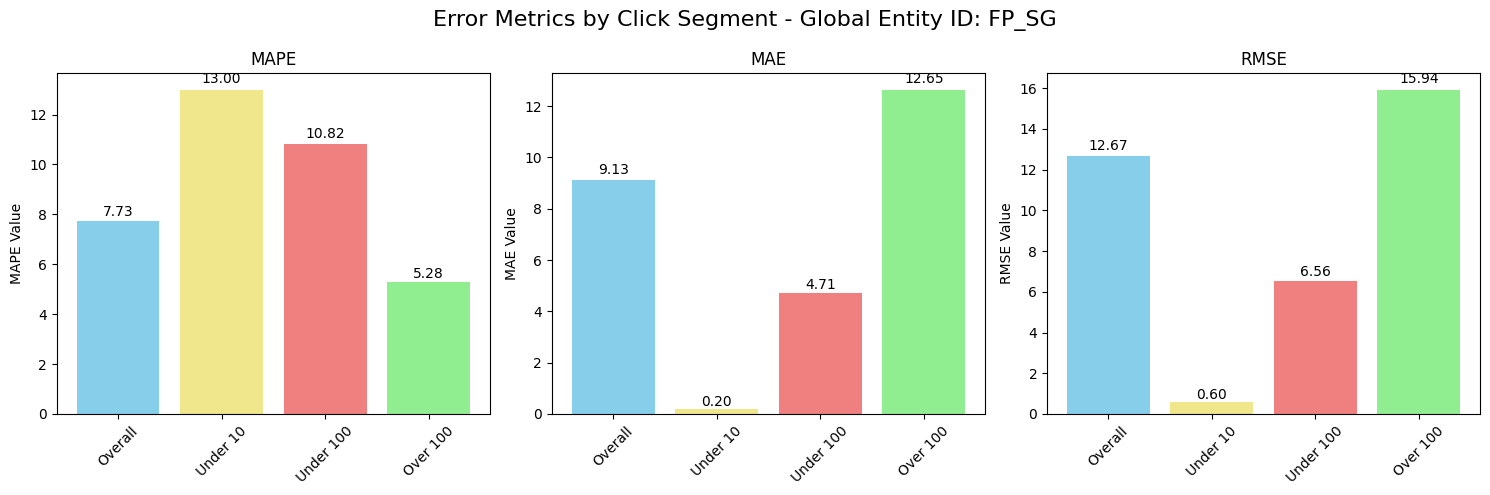

Completed processing for Global Entity ID: FP_SG

Processing Global Entity ID: FP_TW
  Overall:
    MAPE: 4.95%
     MAE: 17.53
    RMSE: 25.11
    Data points: 2059
  Under 10:
    MAPE: 14.70%
     MAE: 0.28
    RMSE: 0.67
    Data points: 80
  Under 100:
    MAPE: 13.47%
     MAE: 3.81
    RMSE: 5.84
    Data points: 223
  Over 100:
    MAPE: 3.91%
     MAE: 19.21
    RMSE: 26.52
    Data points: 1835


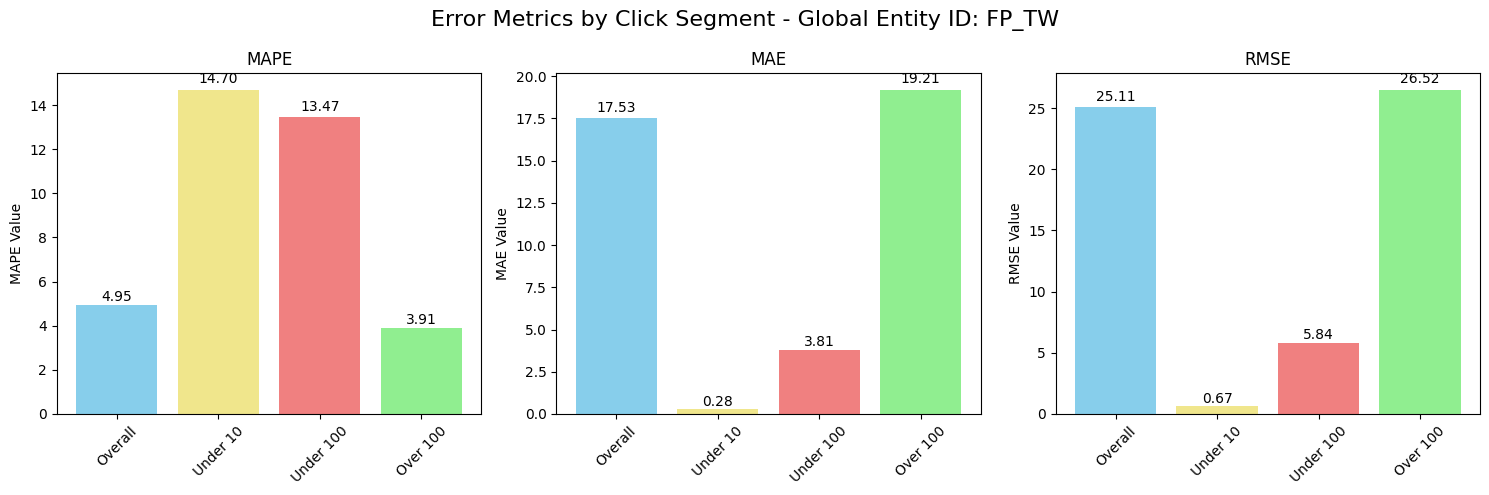

Completed processing for Global Entity ID: FP_TW

Processing Global Entity ID: GV_BA
  Overall:
    MAPE: 5.23%
     MAE: 19.59
    RMSE: 26.49
    Data points: 58
  Under 10: No data points
  Under 100:
    MAPE: 11.50%
     MAE: 7.67
    RMSE: 8.21
    Data points: 6
  Over 100:
    MAPE: 4.51%
     MAE: 20.96
    RMSE: 27.83
    Data points: 52


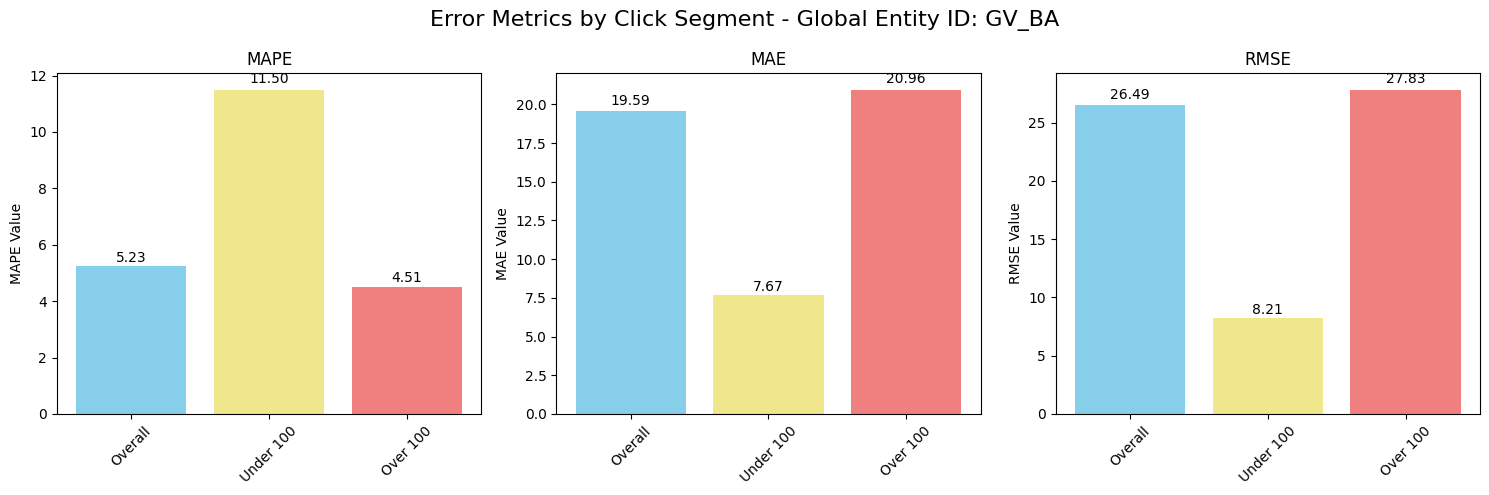

Completed processing for Global Entity ID: GV_BA

Processing Global Entity ID: GV_BG
  Overall:
    MAPE: 4.22%
     MAE: 17.88
    RMSE: 25.77
    Data points: 64
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 1
  Under 100:
    MAPE: 8.29%
     MAE: 4.20
    RMSE: 4.82
    Data points: 10
  Over 100:
    MAPE: 3.47%
     MAE: 20.41
    RMSE: 27.98
    Data points: 54


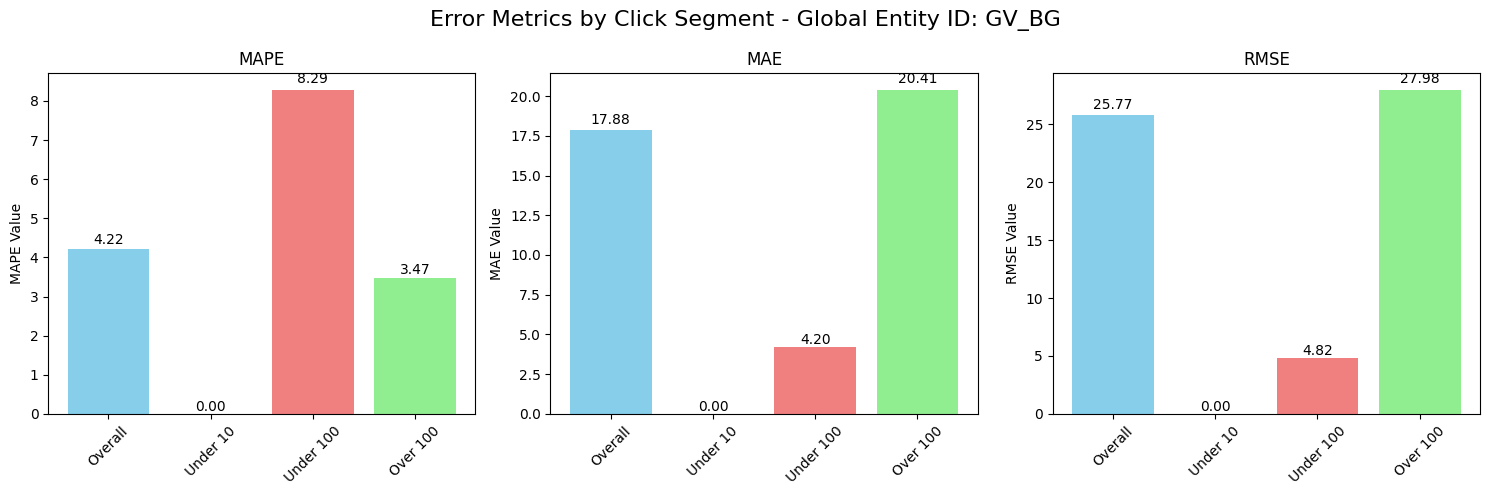

Completed processing for Global Entity ID: GV_BG

Processing Global Entity ID: GV_HR
  Overall:
    MAPE: 5.79%
     MAE: 14.76
    RMSE: 21.71
    Data points: 136
  Under 10:
    MAPE: 20.63%
     MAE: 0.71
    RMSE: 1.56
    Data points: 7
  Under 100:
    MAPE: 13.74%
     MAE: 4.32
    RMSE: 6.80
    Data points: 31
  Over 100:
    MAPE: 3.44%
     MAE: 17.84
    RMSE: 24.43
    Data points: 105


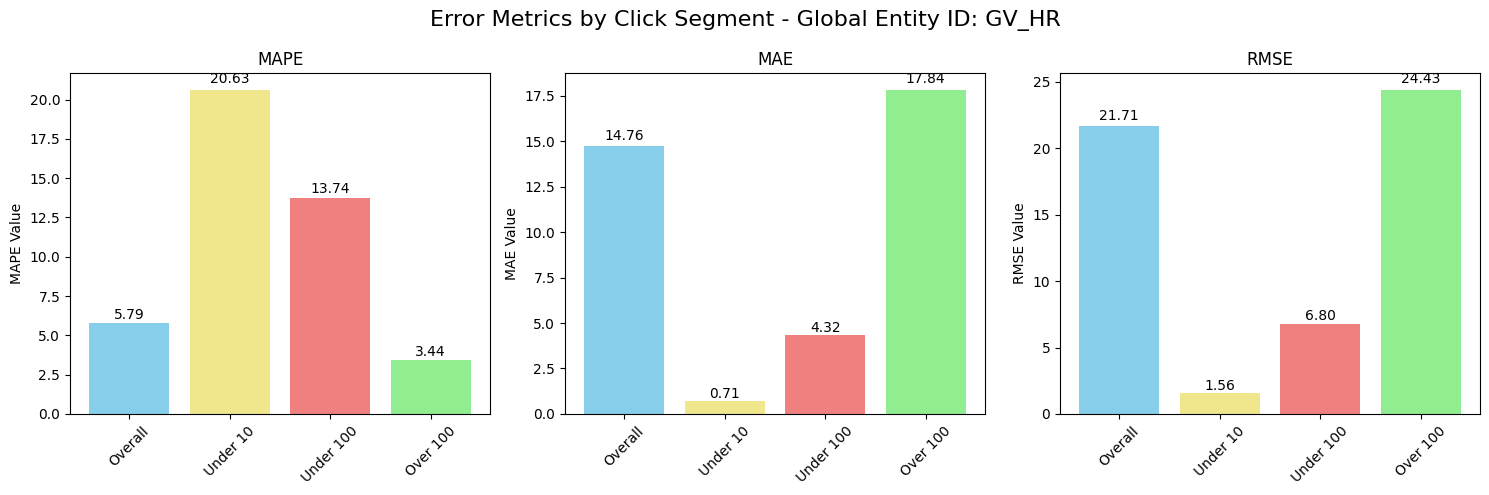

Completed processing for Global Entity ID: GV_HR

Processing Global Entity ID: GV_GE
  Overall:
    MAPE: 11.11%
     MAE: 0.44
    RMSE: 1.33
    Data points: 9
  Under 10:
    MAPE: 11.11%
     MAE: 0.44
    RMSE: 1.33
    Data points: 9
  Under 100:
    MAPE: 11.11%
     MAE: 0.44
    RMSE: 1.33
    Data points: 9
  Over 100: No data points


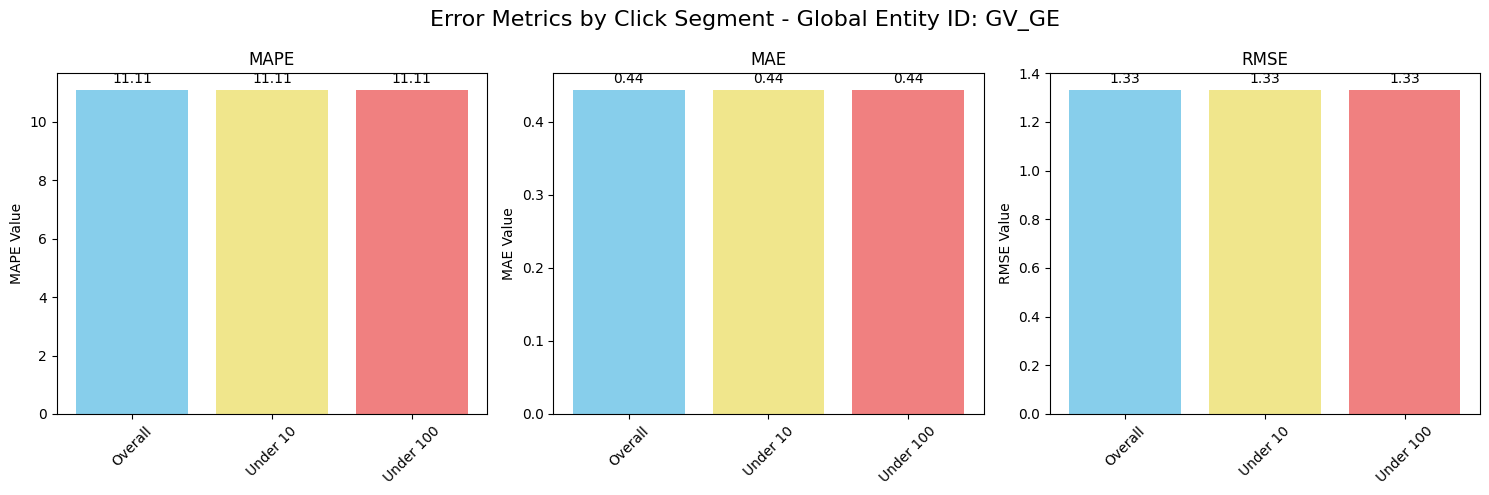

Completed processing for Global Entity ID: GV_GE

Processing Global Entity ID: GV_CI
  Overall:
    MAPE: 2.89%
     MAE: 34.45
    RMSE: 48.24
    Data points: 60
  Under 10:
    MAPE: 12.50%
     MAE: 0.50
    RMSE: 0.71
    Data points: 2
  Under 100:
    MAPE: 8.79%
     MAE: 2.20
    RMSE: 3.26
    Data points: 5
  Over 100:
    MAPE: 2.35%
     MAE: 37.38
    RMSE: 50.37
    Data points: 55


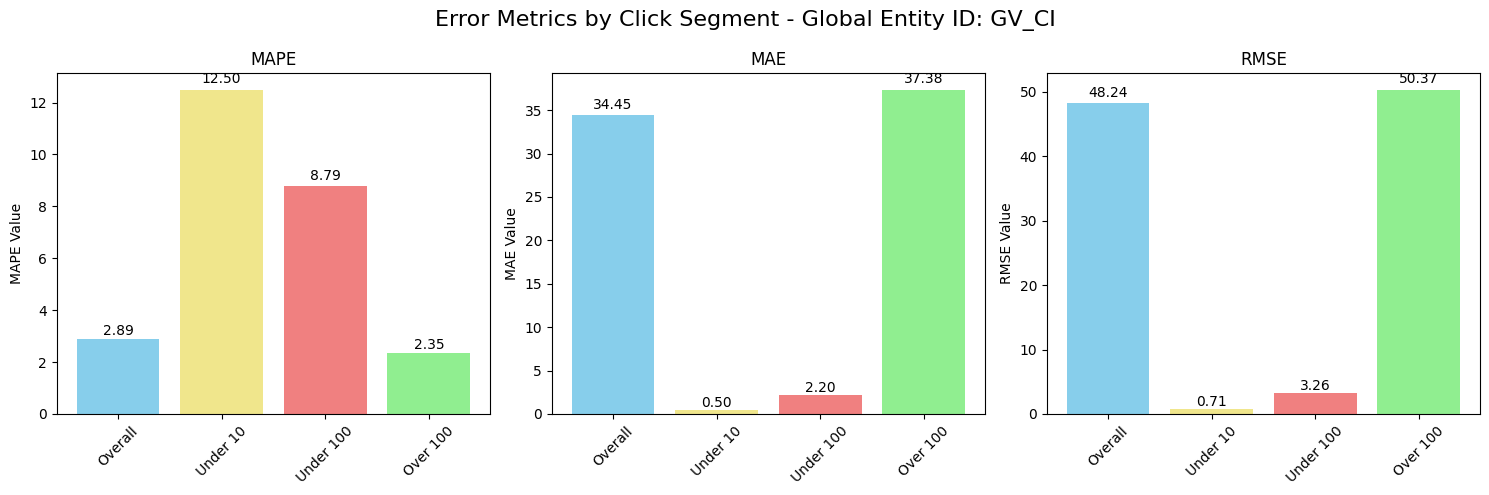

Completed processing for Global Entity ID: GV_CI

Processing Global Entity ID: GV_KE
  Overall:
    MAPE: 7.68%
     MAE: 11.19
    RMSE: 17.31
    Data points: 146
  Under 10:
    MAPE: 14.47%
     MAE: 0.21
    RMSE: 0.46
    Data points: 19
  Under 100:
    MAPE: 12.53%
     MAE: 2.92
    RMSE: 4.64
    Data points: 52
  Over 100:
    MAPE: 5.01%
     MAE: 15.77
    RMSE: 21.29
    Data points: 94


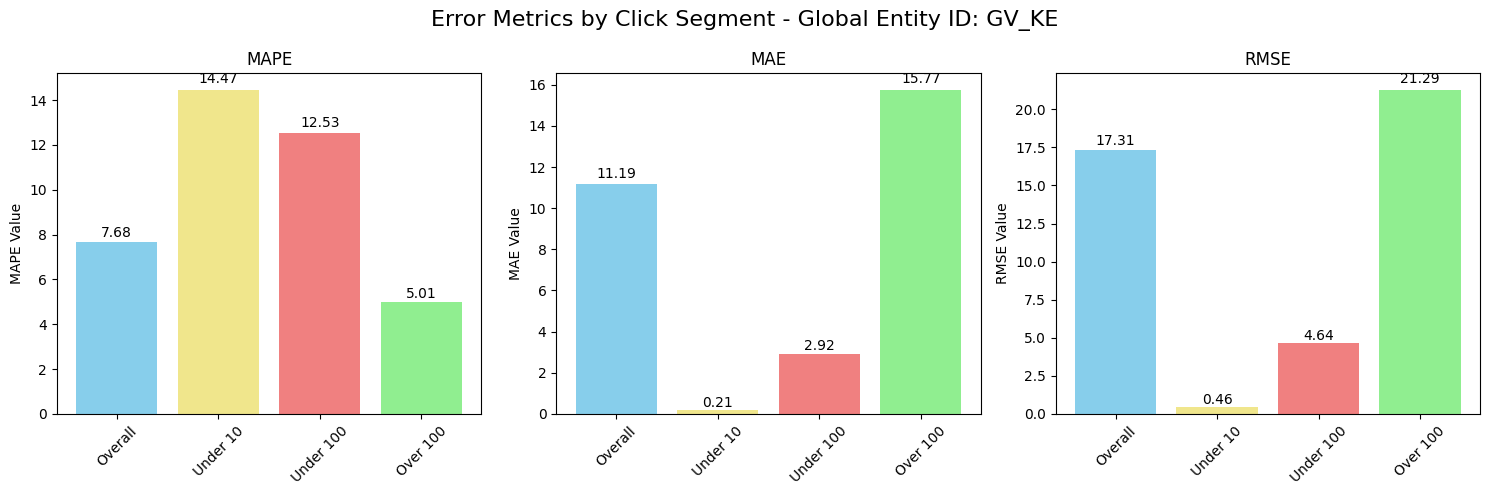

Completed processing for Global Entity ID: GV_KE

Processing Global Entity ID: GV_MD
  Overall:
    MAPE: 4.44%
     MAE: 15.82
    RMSE: 21.82
    Data points: 55
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 1
  Under 100:
    MAPE: 10.11%
     MAE: 4.00
    RMSE: 5.06
    Data points: 10
  Over 100:
    MAPE: 3.18%
     MAE: 18.44
    RMSE: 24.01
    Data points: 45


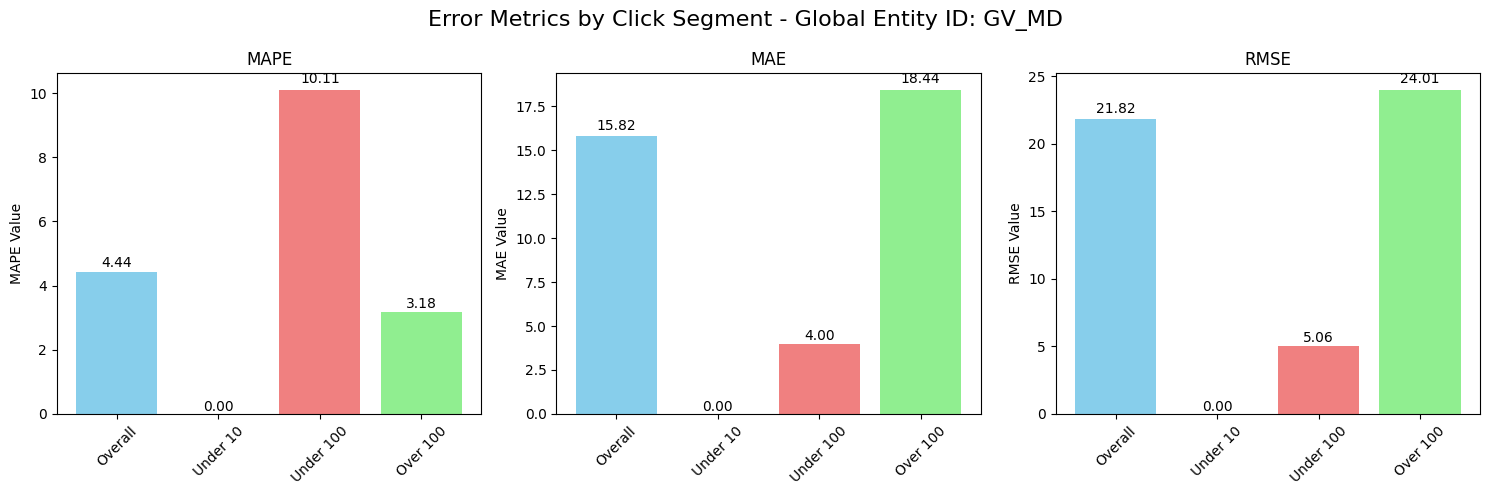

Completed processing for Global Entity ID: GV_MD

Processing Global Entity ID: GV_ME
  Overall:
    MAPE: 3.71%
     MAE: 23.21
    RMSE: 30.44
    Data points: 89
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 3
  Under 100:
    MAPE: 6.31%
     MAE: 6.00
    RMSE: 9.82
    Data points: 5
  Over 100:
    MAPE: 3.55%
     MAE: 24.24
    RMSE: 31.24
    Data points: 84


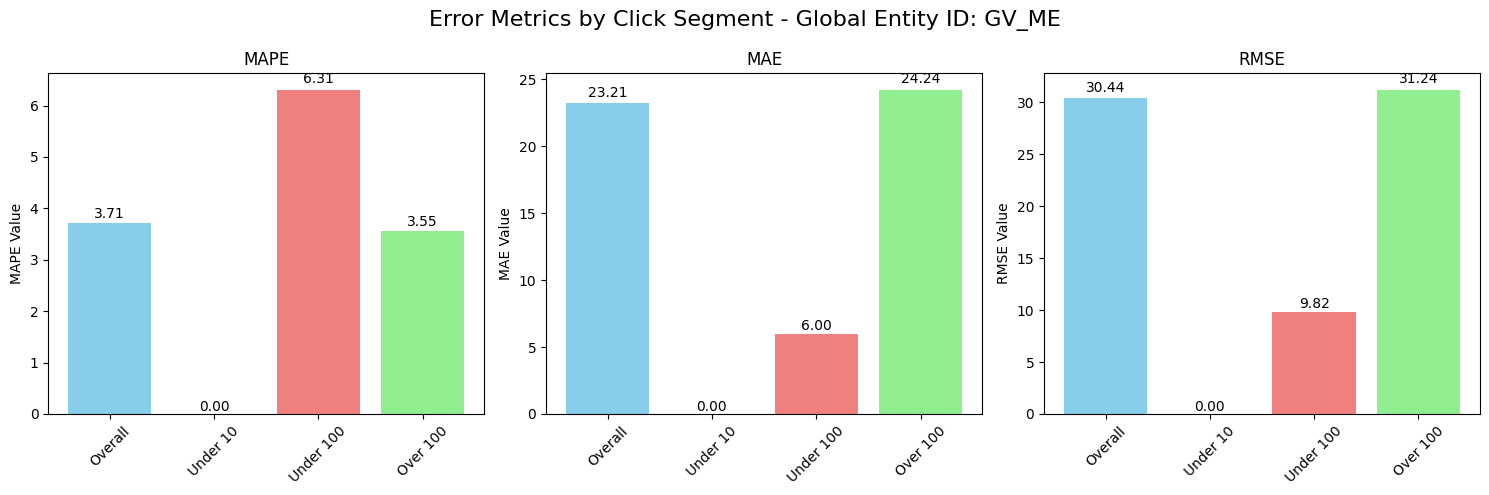

Completed processing for Global Entity ID: GV_ME

Processing Global Entity ID: GV_MA
  Overall:
    MAPE: 2.58%
     MAE: 39.00
    RMSE: 53.51
    Data points: 477
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 15
  Under 100:
    MAPE: 7.12%
     MAE: 3.23
    RMSE: 5.30
    Data points: 31
  Over 100:
    MAPE: 2.27%
     MAE: 41.49
    RMSE: 55.32
    Data points: 446


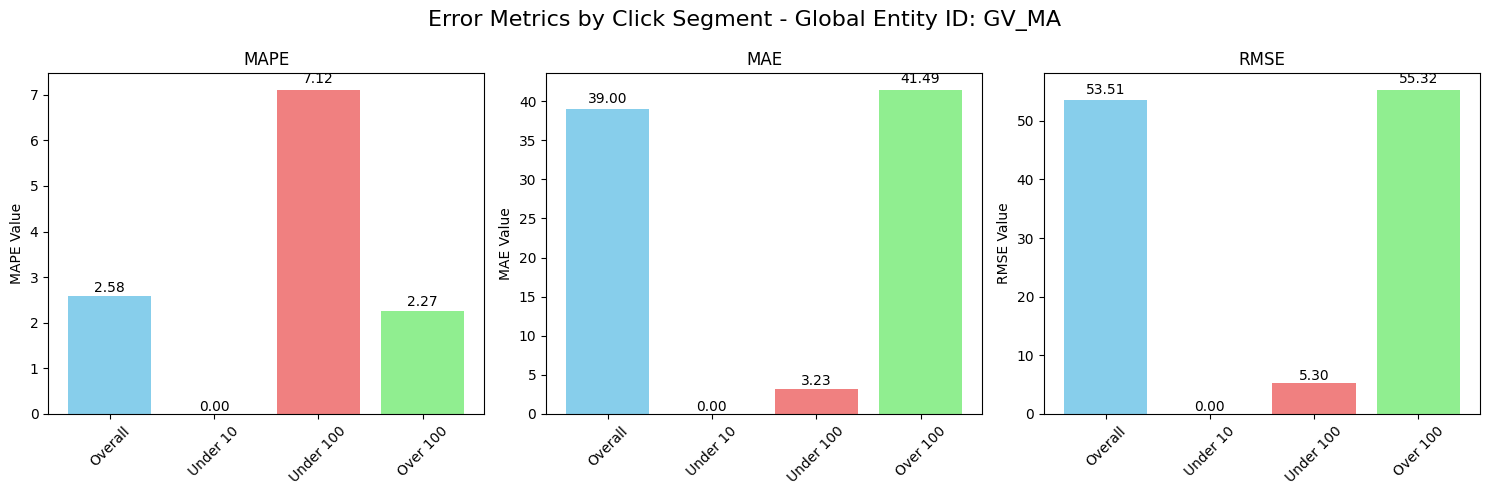

Completed processing for Global Entity ID: GV_MA

Processing Global Entity ID: GV_NG
  Overall:
    MAPE: 10.30%
     MAE: 9.12
    RMSE: 17.56
    Data points: 340
  Under 10:
    MAPE: 8.65%
     MAE: 0.55
    RMSE: 1.23
    Data points: 64
  Under 100:
    MAPE: 12.22%
     MAE: 4.21
    RMSE: 6.23
    Data points: 253
  Over 100:
    MAPE: 4.77%
     MAE: 23.65
    RMSE: 33.24
    Data points: 86


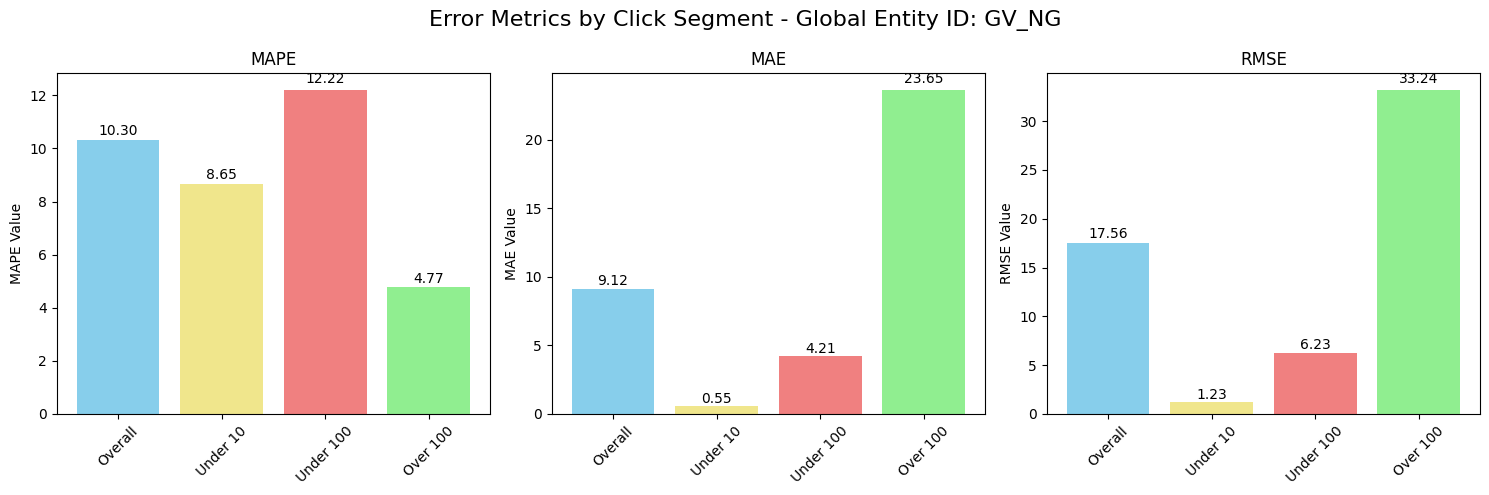

Completed processing for Global Entity ID: GV_NG

Processing Global Entity ID: GV_PL
  Overall:
    MAPE: 6.70%
     MAE: 14.05
    RMSE: 21.65
    Data points: 363
  Under 10:
    MAPE: 14.66%
     MAE: 0.72
    RMSE: 1.38
    Data points: 39
  Under 100:
    MAPE: 14.19%
     MAE: 3.02
    RMSE: 4.57
    Data points: 95
  Over 100:
    MAPE: 4.06%
     MAE: 18.14
    RMSE: 25.19
    Data points: 265


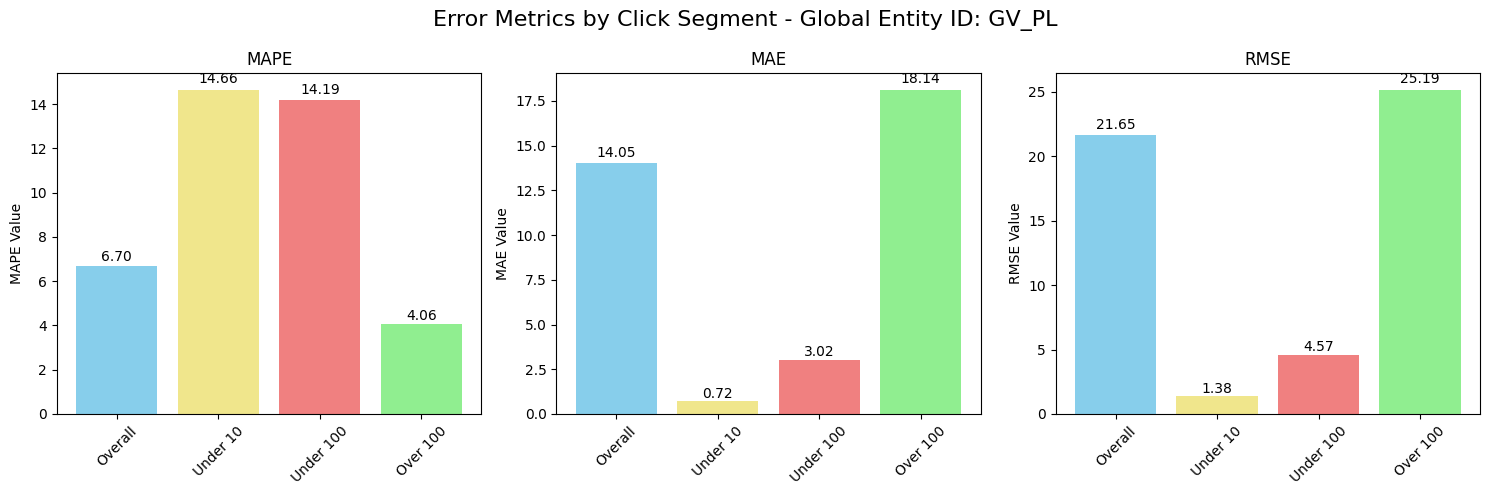

Completed processing for Global Entity ID: GV_PL

Processing Global Entity ID: GV_PT
  Overall:
    MAPE: 8.83%
     MAE: 14.04
    RMSE: 22.58
    Data points: 2689
  Under 10:
    MAPE: 22.30%
     MAE: 0.71
    RMSE: 1.37
    Data points: 439
  Under 100:
    MAPE: 18.17%
     MAE: 2.90
    RMSE: 4.99
    Data points: 883
  Over 100:
    MAPE: 4.26%
     MAE: 19.54
    RMSE: 27.38
    Data points: 1800


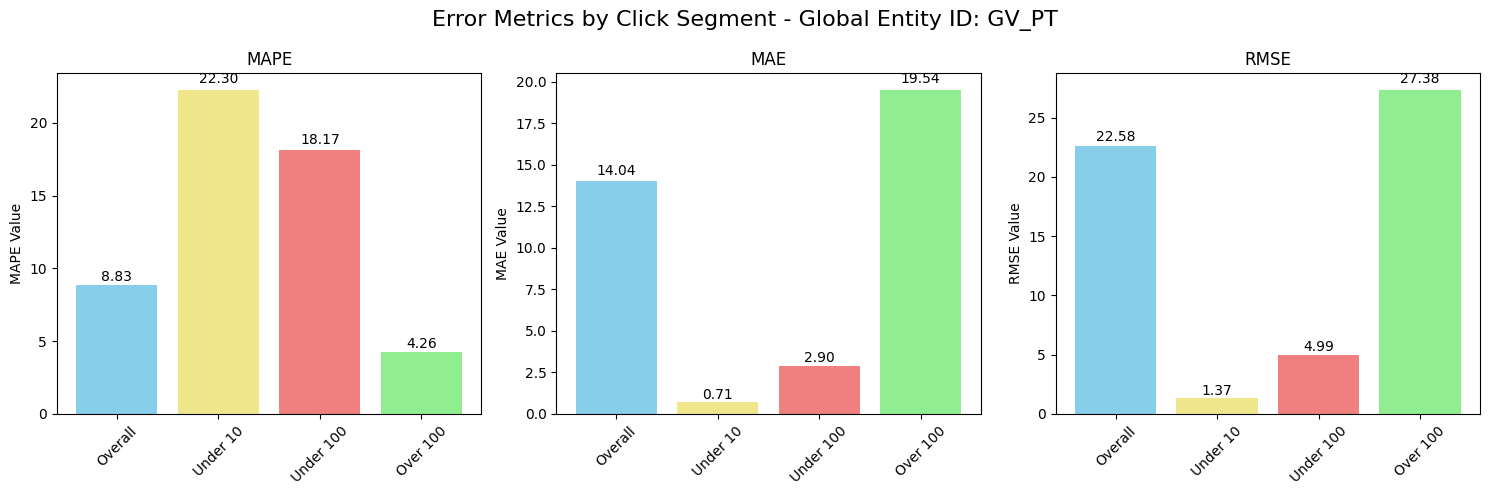

Completed processing for Global Entity ID: GV_PT

Processing Global Entity ID: GV_RO
  Overall:
    MAPE: 3.79%
     MAE: 21.80
    RMSE: 32.74
    Data points: 466
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 19
  Under 100:
    MAPE: 7.96%
     MAE: 3.41
    RMSE: 5.77
    Data points: 46
  Over 100:
    MAPE: 3.33%
     MAE: 23.85
    RMSE: 34.48
    Data points: 419


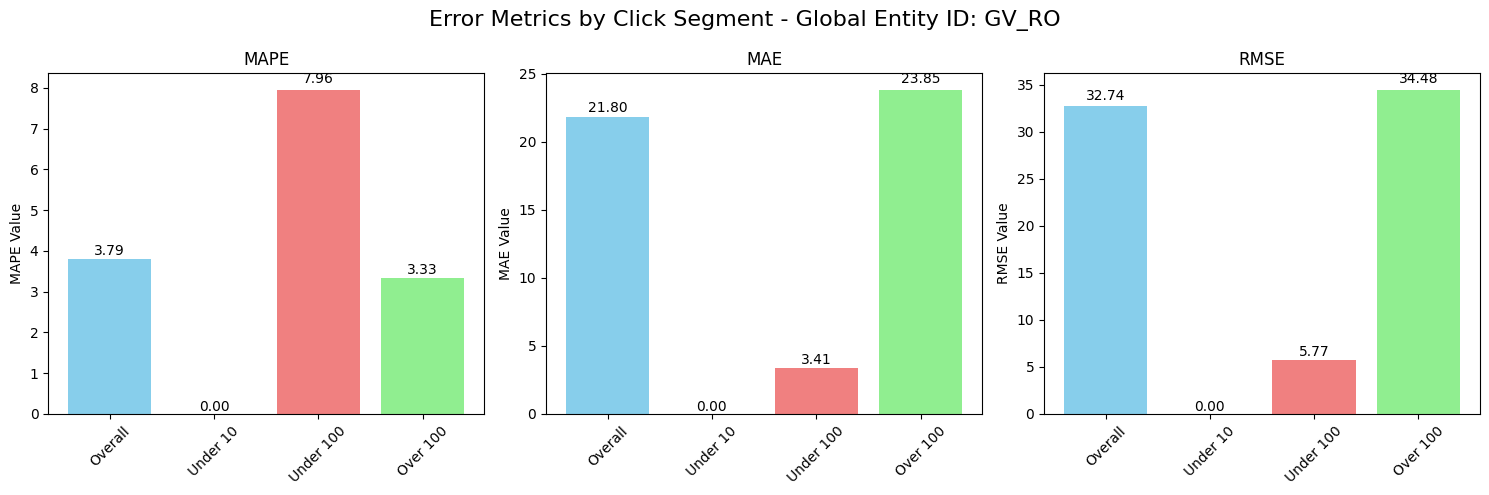

Completed processing for Global Entity ID: GV_RO

Processing Global Entity ID: GV_RS
  Overall:
    MAPE: 4.14%
     MAE: 18.70
    RMSE: 26.15
    Data points: 203
  Under 10:
    MAPE: 3.33%
     MAE: 0.20
    RMSE: 0.45
    Data points: 5
  Under 100:
    MAPE: 10.80%
     MAE: 4.69
    RMSE: 6.50
    Data points: 29
  Over 100:
    MAPE: 3.03%
     MAE: 21.03
    RMSE: 28.12
    Data points: 174


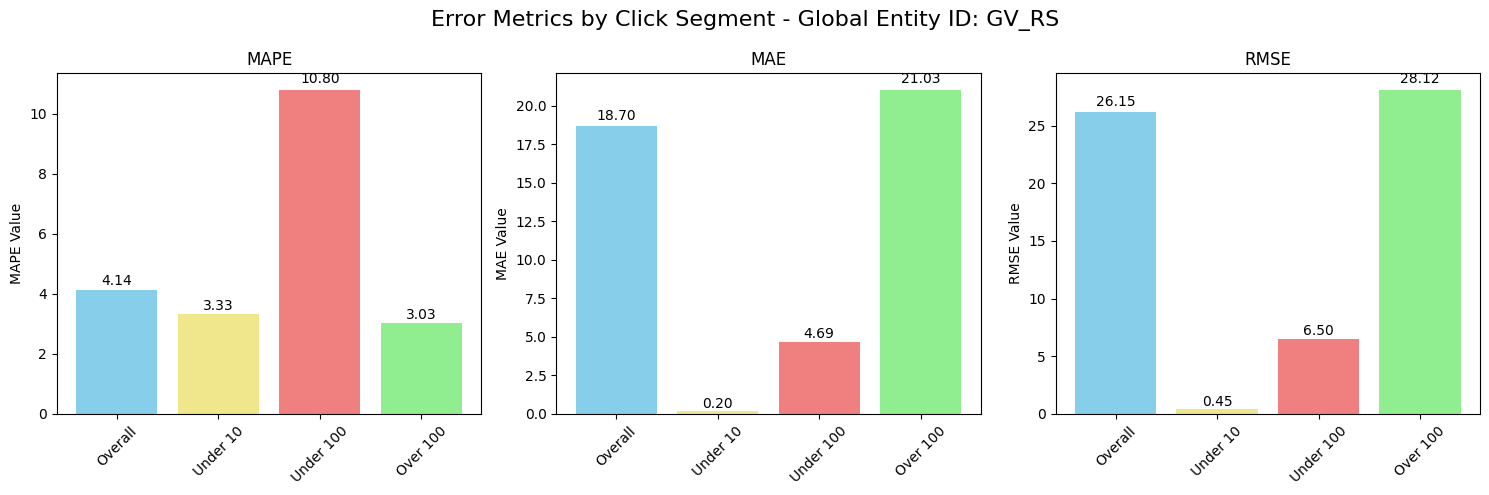

Completed processing for Global Entity ID: GV_RS

Processing Global Entity ID: GV_TN
  Overall:
    MAPE: 6.83%
     MAE: 19.18
    RMSE: 30.27
    Data points: 253
  Under 10:
    MAPE: 8.80%
     MAE: 0.64
    RMSE: 1.83
    Data points: 11
  Under 100:
    MAPE: 13.17%
     MAE: 5.37
    RMSE: 7.68
    Data points: 73
  Over 100:
    MAPE: 4.25%
     MAE: 24.78
    RMSE: 35.56
    Data points: 180


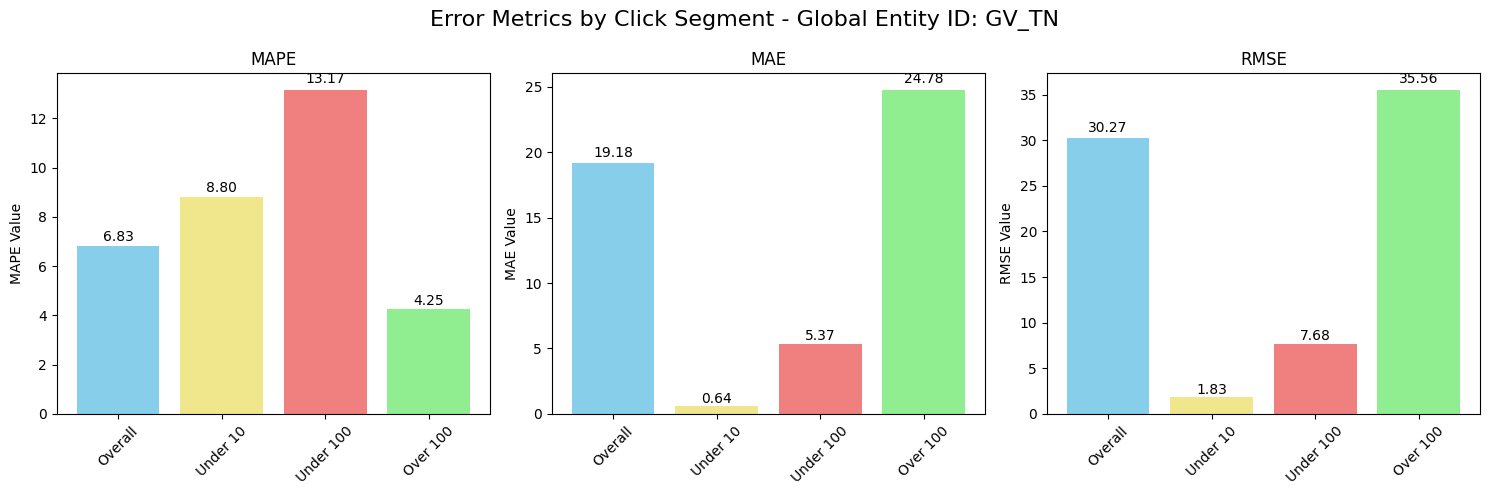

Completed processing for Global Entity ID: GV_TN

Processing Global Entity ID: GV_UG
  Overall:
    MAPE: 3.31%
     MAE: 25.06
    RMSE: 31.78
    Data points: 31
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 4
  Under 100:
    MAPE: 8.34%
     MAE: 6.29
    RMSE: 9.84
    Data points: 7
  Over 100:
    MAPE: 1.84%
     MAE: 30.54
    RMSE: 35.72
    Data points: 24


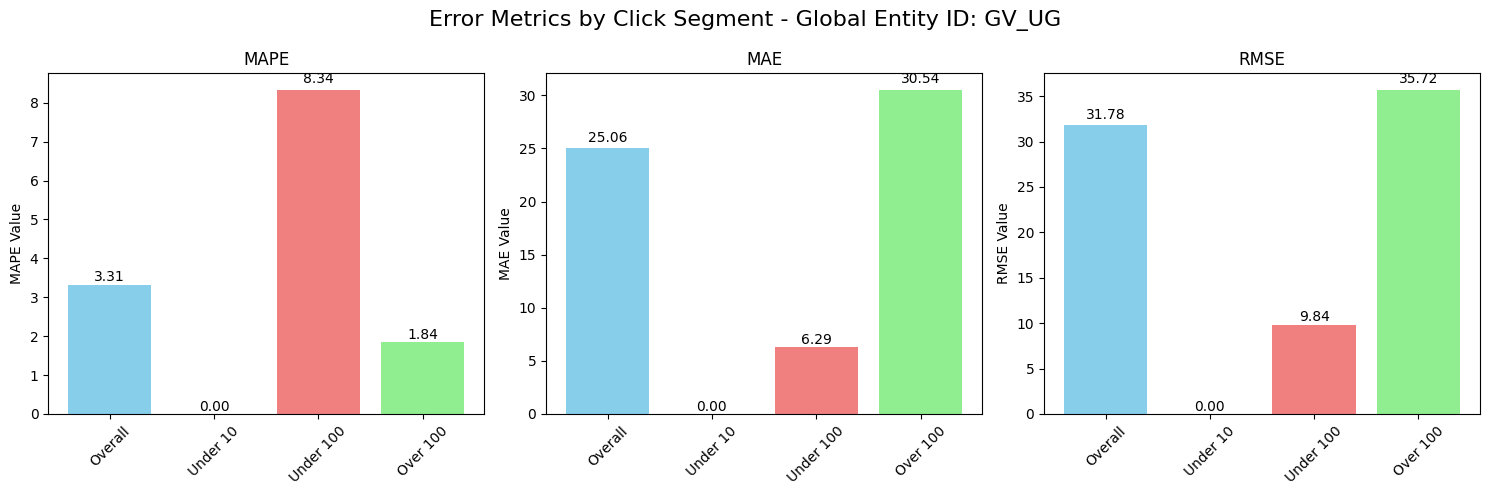

Completed processing for Global Entity ID: GV_UG

Processing Global Entity ID: GV_UA
  Overall:
    MAPE: 15.13%
     MAE: 0.62
    RMSE: 1.46
    Data points: 8
  Under 10:
    MAPE: 14.29%
     MAE: 0.14
    RMSE: 0.38
    Data points: 7
  Under 100:
    MAPE: 15.13%
     MAE: 0.62
    RMSE: 1.46
    Data points: 8
  Over 100: No data points


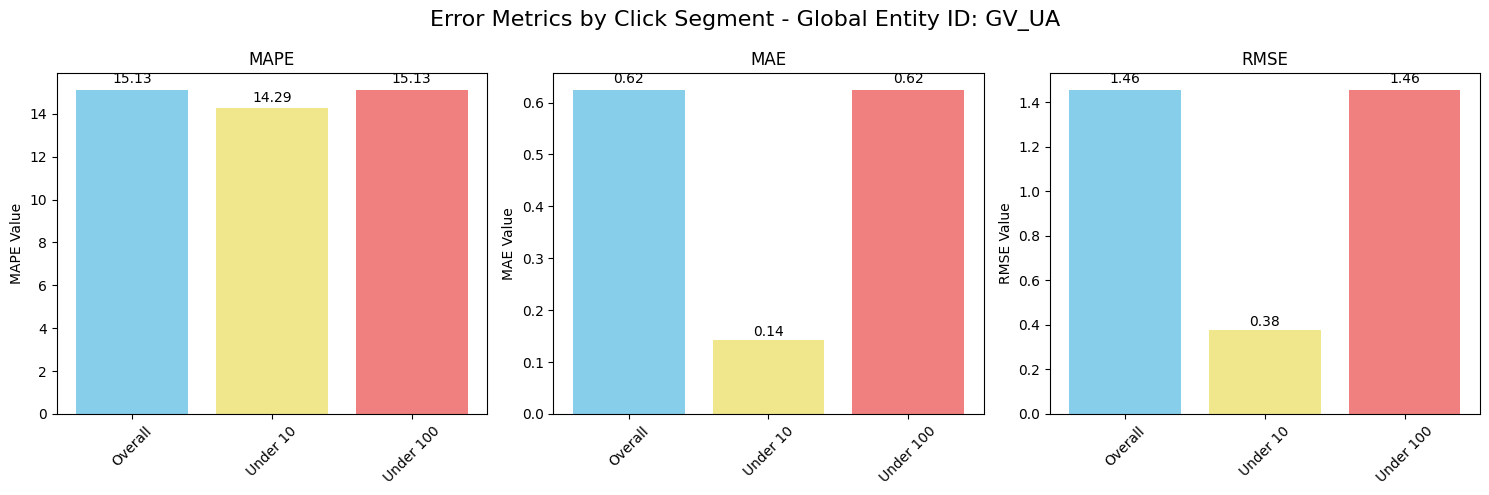

Completed processing for Global Entity ID: GV_UA

Processing Global Entity ID: HS_SA
  Overall:
    MAPE: 4.59%
     MAE: 19.74
    RMSE: 28.63
    Data points: 905
  Under 10:
    MAPE: 10.67%
     MAE: 0.31
    RMSE: 0.73
    Data points: 54
  Under 100:
    MAPE: 11.18%
     MAE: 3.09
    RMSE: 4.86
    Data points: 134
  Over 100:
    MAPE: 3.45%
     MAE: 22.64
    RMSE: 30.95
    Data points: 771


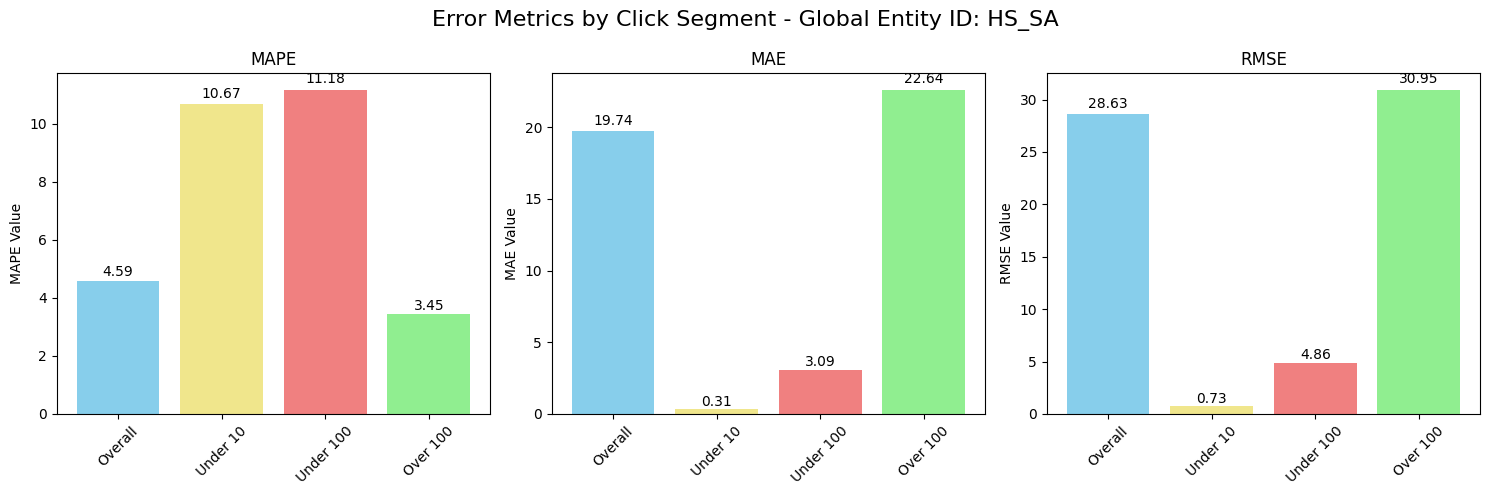

Completed processing for Global Entity ID: HS_SA

Processing Global Entity ID: PY_AR
  Overall:
    MAPE: 6.56%
     MAE: 17.14
    RMSE: 26.57
    Data points: 2909
  Under 10:
    MAPE: 28.01%
     MAE: 1.12
    RMSE: 1.91
    Data points: 84
  Under 100:
    MAPE: 14.24%
     MAE: 5.13
    RMSE: 6.96
    Data points: 743
  Over 100:
    MAPE: 3.92%
     MAE: 21.31
    RMSE: 30.57
    Data points: 2158


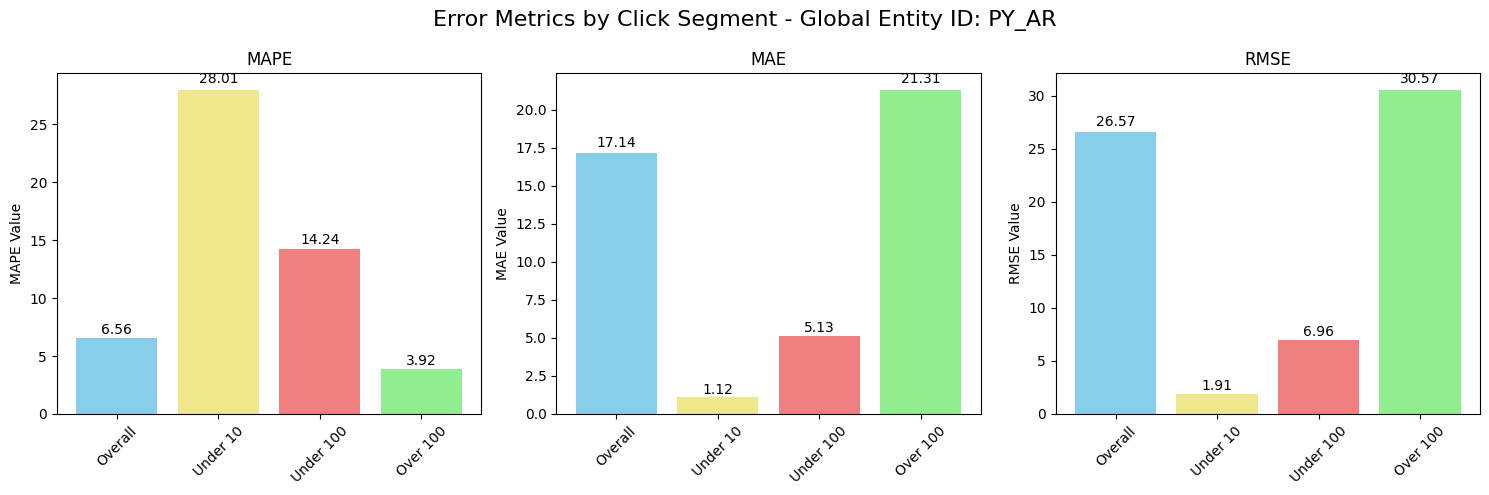

Completed processing for Global Entity ID: PY_AR

Processing Global Entity ID: PY_BO
  Overall:
    MAPE: 5.58%
     MAE: 14.06
    RMSE: 18.77
    Data points: 208
  Under 10:
    MAPE: 33.33%
     MAE: 0.33
    RMSE: 0.58
    Data points: 3
  Under 100:
    MAPE: 12.93%
     MAE: 4.96
    RMSE: 6.39
    Data points: 24
  Over 100:
    MAPE: 4.63%
     MAE: 15.25
    RMSE: 19.82
    Data points: 184


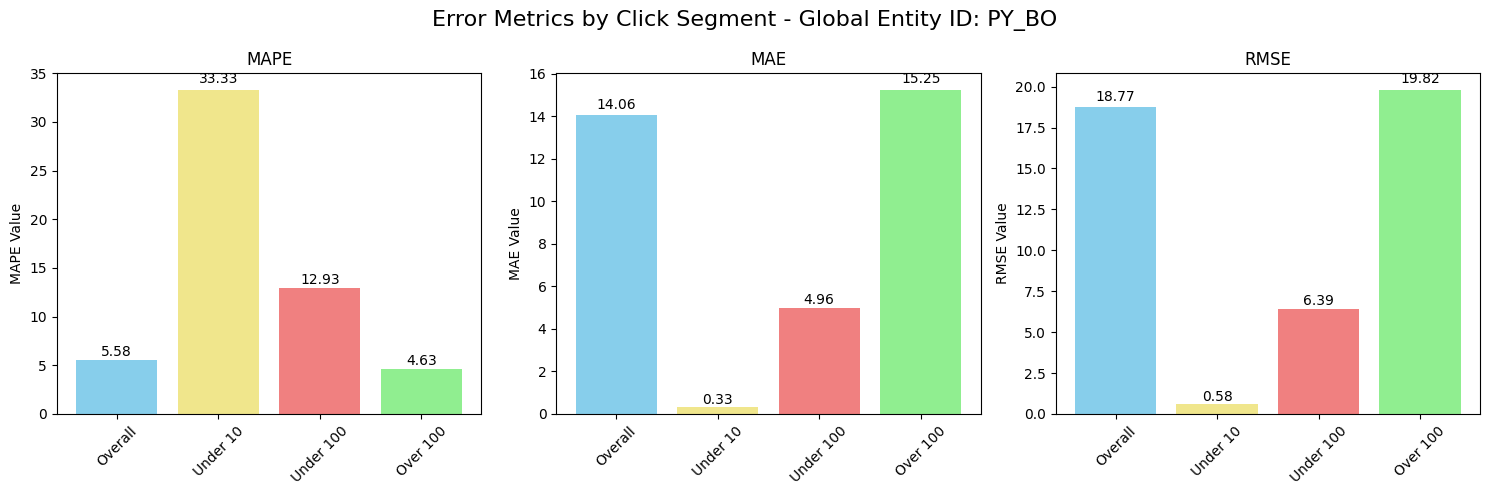

Completed processing for Global Entity ID: PY_BO

Processing Global Entity ID: PY_CL
  Overall:
    MAPE: 4.16%
     MAE: 21.19
    RMSE: 28.72
    Data points: 951
  Under 10:
    MAPE: 49.40%
     MAE: 0.88
    RMSE: 1.46
    Data points: 8
  Under 100:
    MAPE: 15.15%
     MAE: 4.74
    RMSE: 6.56
    Data points: 57
  Over 100:
    MAPE: 3.45%
     MAE: 22.23
    RMSE: 29.57
    Data points: 894


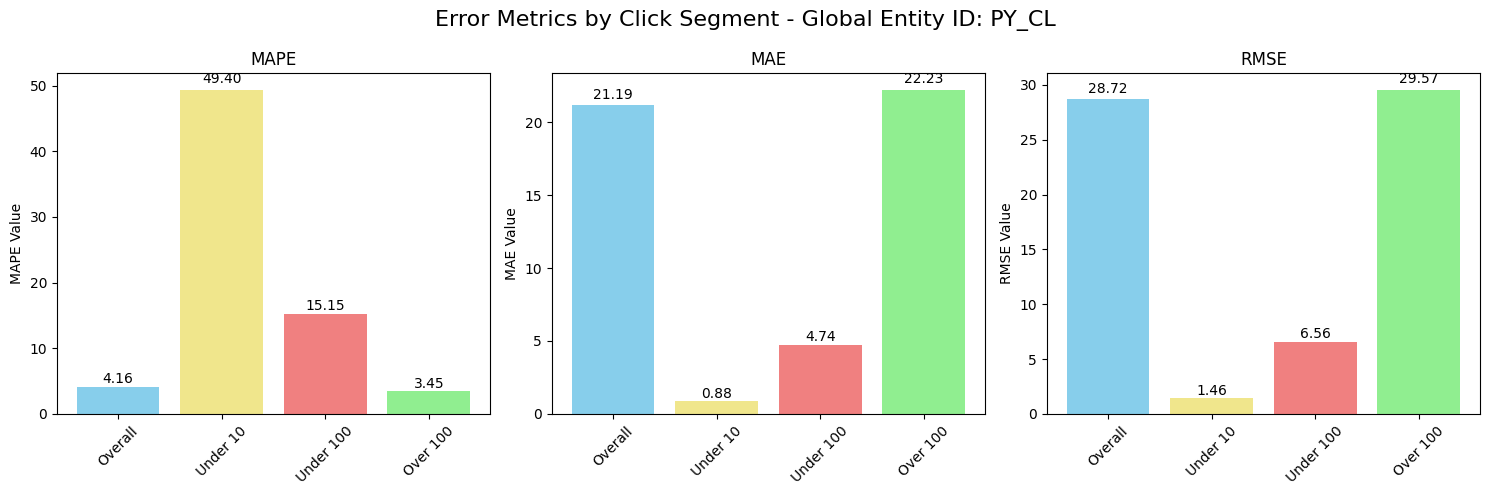

Completed processing for Global Entity ID: PY_CL

Processing Global Entity ID: PY_CR
  Overall:
    MAPE: 5.97%
     MAE: 13.28
    RMSE: 17.72
    Data points: 146
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 2
  Under 100:
    MAPE: 8.15%
     MAE: 5.08
    RMSE: 6.70
    Data points: 26
  Over 100:
    MAPE: 5.51%
     MAE: 15.15
    RMSE: 19.37
    Data points: 119


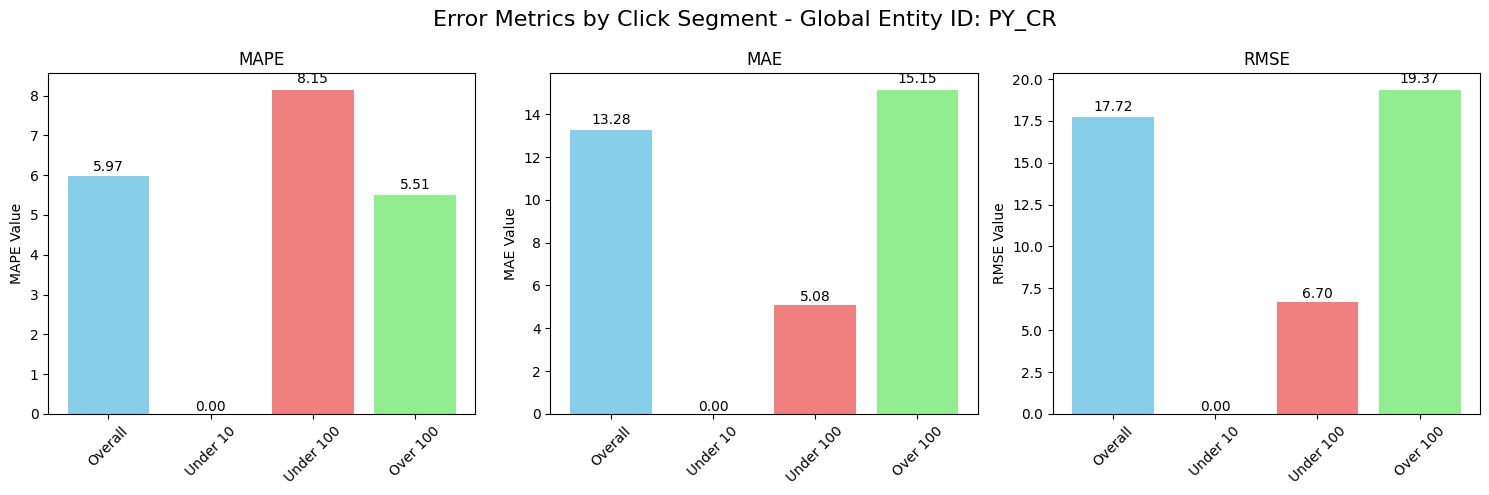

Completed processing for Global Entity ID: PY_CR

Processing Global Entity ID: PY_DO
  Overall:
    MAPE: 8.42%
     MAE: 12.78
    RMSE: 19.36
    Data points: 312
  Under 10:
    MAPE: 34.86%
     MAE: 0.95
    RMSE: 1.47
    Data points: 20
  Under 100:
    MAPE: 15.95%
     MAE: 5.11
    RMSE: 7.02
    Data points: 106
  Over 100:
    MAPE: 4.50%
     MAE: 16.80
    RMSE: 23.38
    Data points: 204


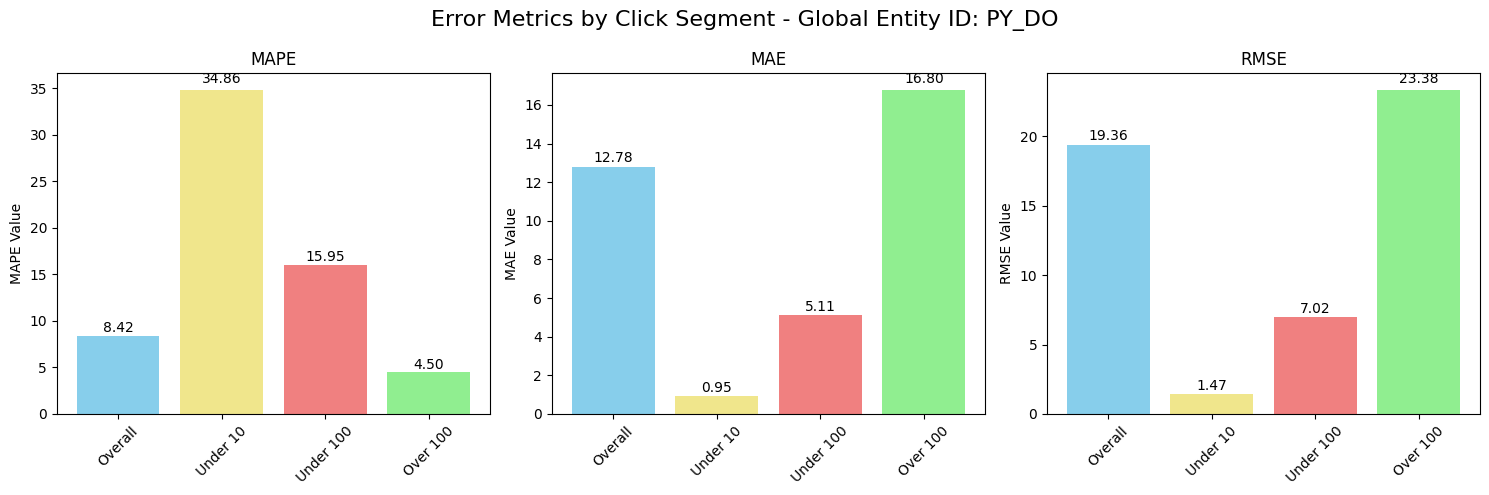

Completed processing for Global Entity ID: PY_DO

Processing Global Entity ID: PY_EC
  Overall:
    MAPE: 8.72%
     MAE: 9.76
    RMSE: 15.05
    Data points: 937
  Under 10:
    MAPE: 20.45%
     MAE: 0.73
    RMSE: 1.41
    Data points: 52
  Under 100:
    MAPE: 13.23%
     MAE: 5.13
    RMSE: 6.95
    Data points: 453
  Over 100:
    MAPE: 4.50%
     MAE: 14.09
    RMSE: 19.83
    Data points: 484


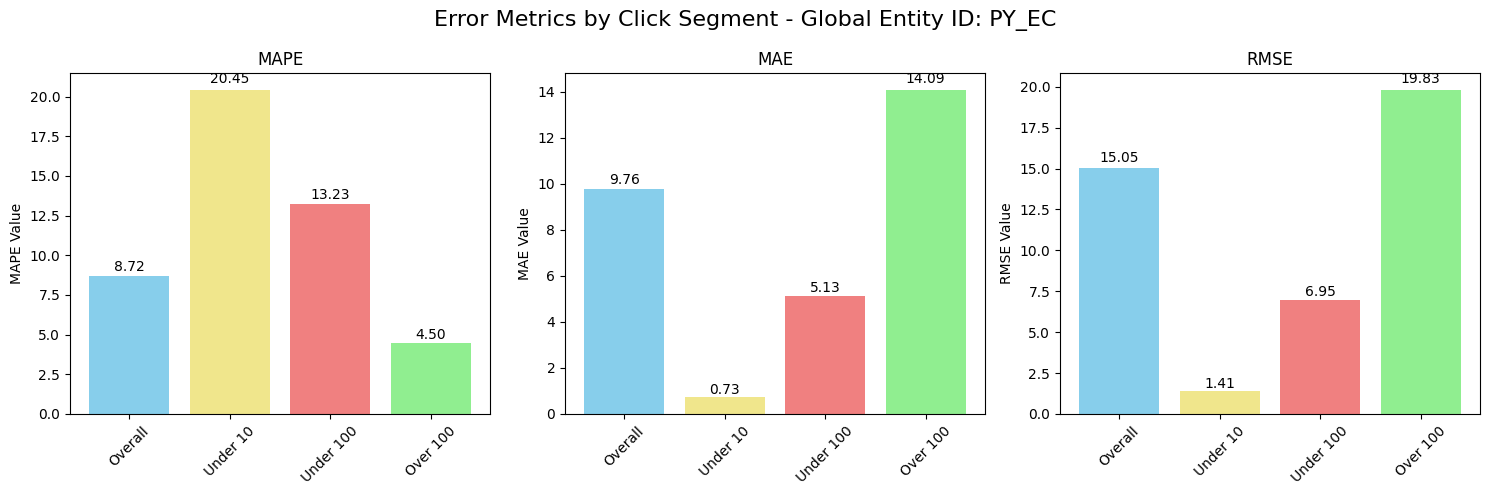

Completed processing for Global Entity ID: PY_EC

Processing Global Entity ID: PY_SV
  Overall:
    MAPE: 6.65%
     MAE: 14.07
    RMSE: 20.14
    Data points: 165
  Under 10:
    MAPE: 42.50%
     MAE: 2.50
    RMSE: 2.55
    Data points: 2
  Under 100:
    MAPE: 12.71%
     MAE: 4.41
    RMSE: 6.28
    Data points: 29
  Over 100:
    MAPE: 5.36%
     MAE: 16.12
    RMSE: 21.99
    Data points: 136


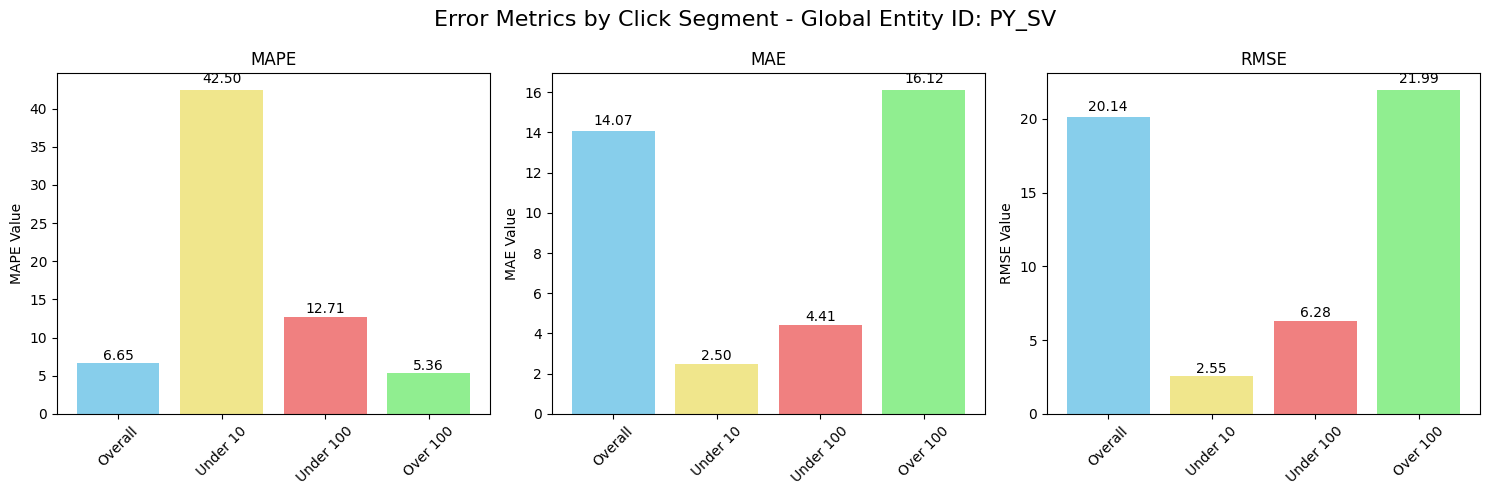

Completed processing for Global Entity ID: PY_SV

Processing Global Entity ID: PY_GT
  Overall:
    MAPE: 4.89%
     MAE: 16.54
    RMSE: 22.01
    Data points: 208
  Under 10: No data points
  Under 100:
    MAPE: 10.97%
     MAE: 6.36
    RMSE: 7.29
    Data points: 11
  Over 100:
    MAPE: 4.53%
     MAE: 17.15
    RMSE: 22.60
    Data points: 196


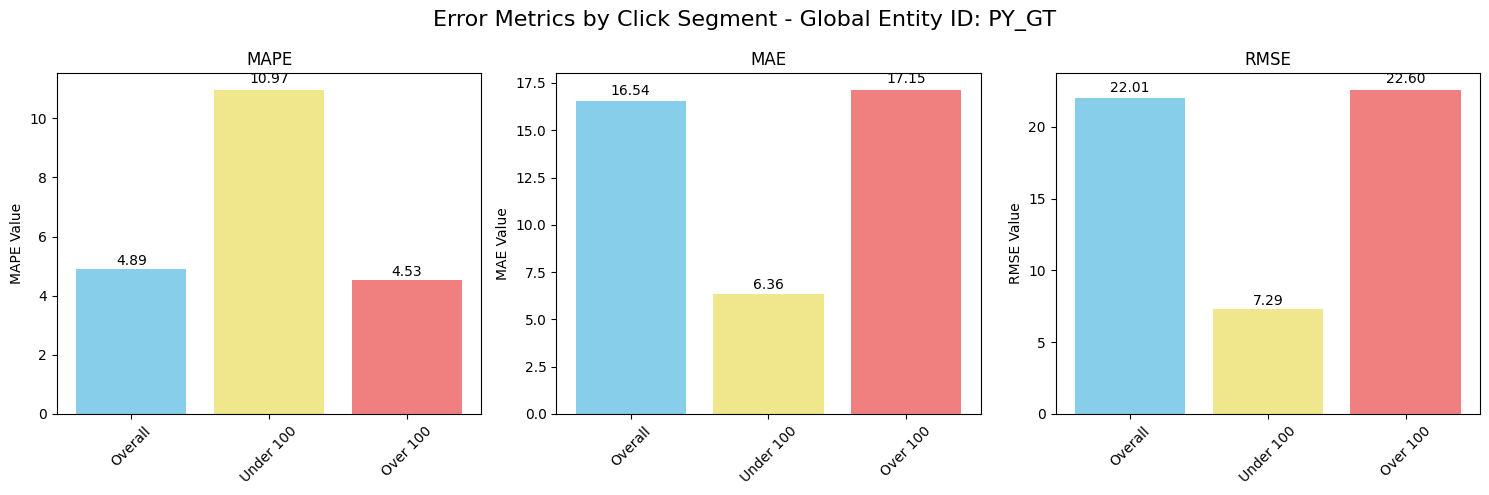

Completed processing for Global Entity ID: PY_GT

Processing Global Entity ID: PY_HN
  Overall:
    MAPE: 5.79%
     MAE: 16.13
    RMSE: 22.86
    Data points: 236
  Under 10:
    MAPE: 18.45%
     MAE: 1.33
    RMSE: 1.83
    Data points: 3
  Under 100:
    MAPE: 12.48%
     MAE: 4.65
    RMSE: 6.05
    Data points: 49
  Over 100:
    MAPE: 4.04%
     MAE: 19.14
    RMSE: 25.49
    Data points: 187


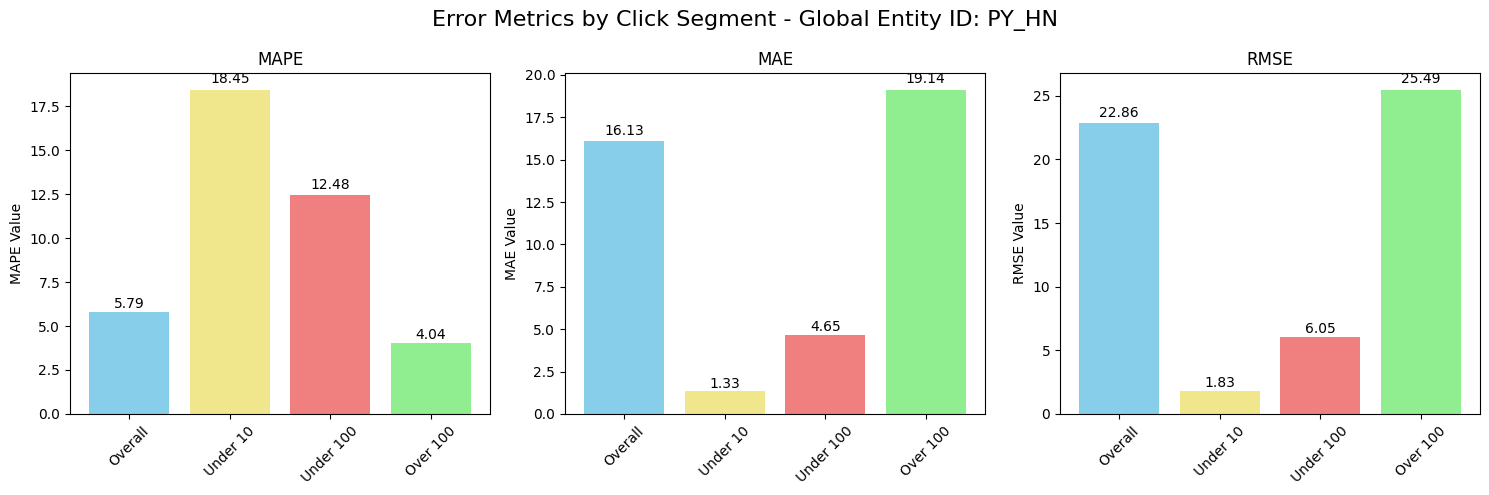

Completed processing for Global Entity ID: PY_HN

Processing Global Entity ID: PY_NI
  Overall:
    MAPE: 7.71%
     MAE: 12.95
    RMSE: 16.17
    Data points: 39
  Under 10: No data points
  Under 100:
    MAPE: 19.43%
     MAE: 5.20
    RMSE: 6.39
    Data points: 5
  Over 100:
    MAPE: 5.98%
     MAE: 14.09
    RMSE: 17.15
    Data points: 34


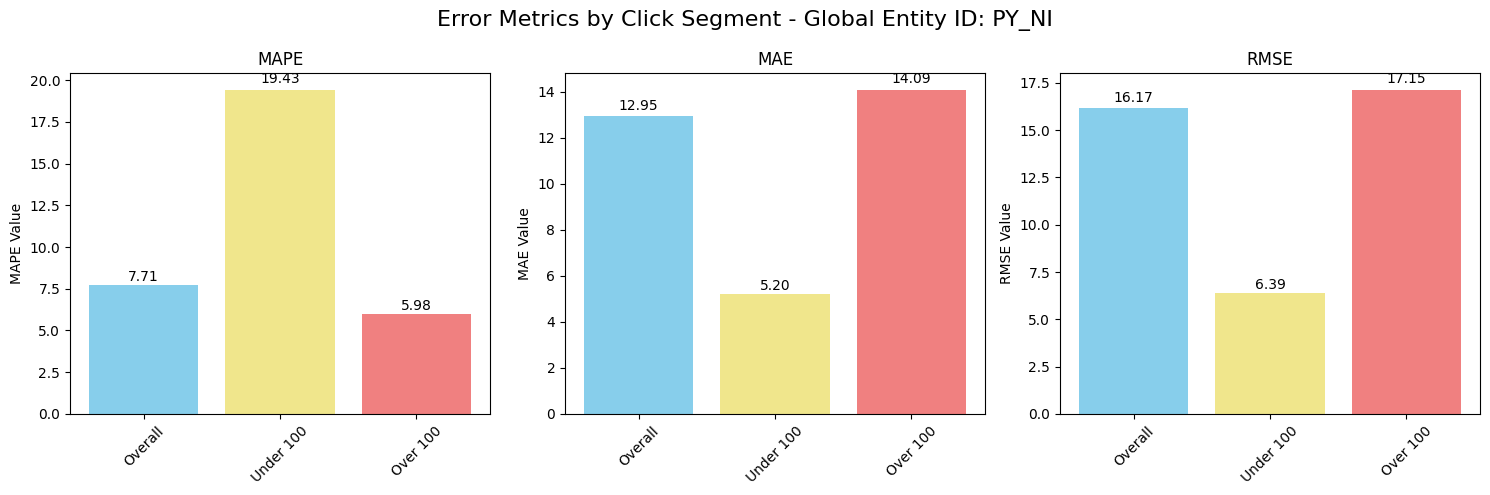

Completed processing for Global Entity ID: PY_NI

Processing Global Entity ID: AP_PA
  Overall:
    MAPE: 5.22%
     MAE: 16.32
    RMSE: 22.34
    Data points: 322
  Under 10:
    MAPE: 48.21%
     MAE: 1.50
    RMSE: 1.87
    Data points: 4
  Under 100:
    MAPE: 14.02%
     MAE: 5.23
    RMSE: 7.27
    Data points: 39
  Over 100:
    MAPE: 3.87%
     MAE: 17.87
    RMSE: 23.73
    Data points: 280


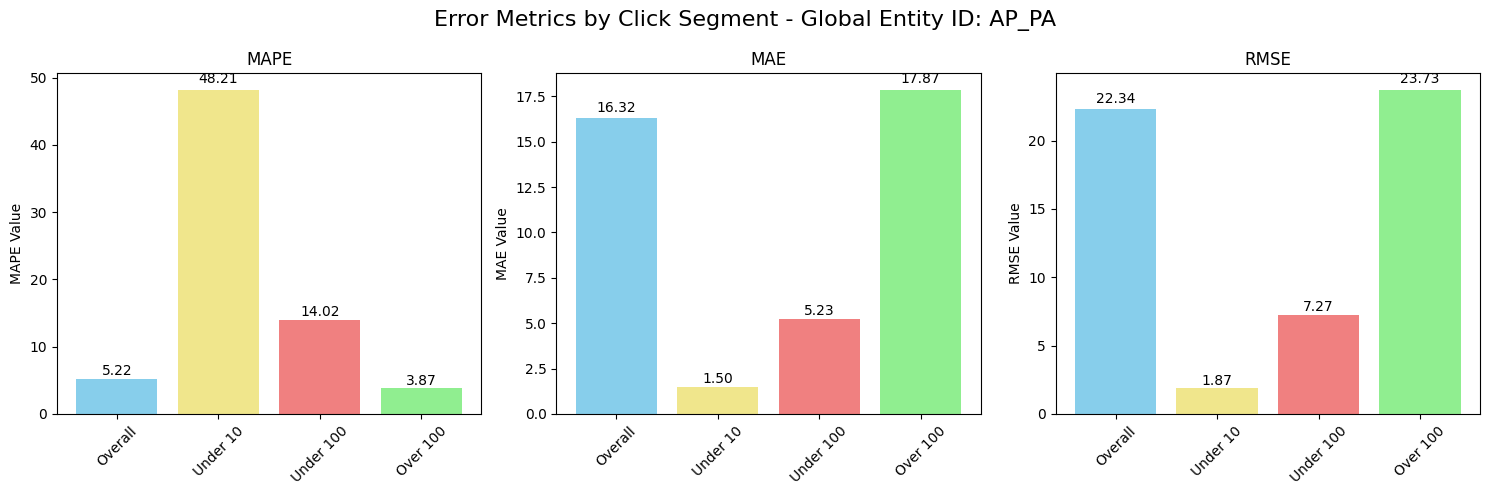

Completed processing for Global Entity ID: AP_PA

Processing Global Entity ID: PY_PY
  Overall:
    MAPE: 7.60%
     MAE: 10.05
    RMSE: 13.72
    Data points: 105
  Under 10:
    MAPE: 10.32%
     MAE: 0.83
    RMSE: 1.47
    Data points: 6
  Under 100:
    MAPE: 11.17%
     MAE: 5.38
    RMSE: 6.77
    Data points: 40
  Over 100:
    MAPE: 5.41%
     MAE: 12.92
    RMSE: 16.60
    Data points: 65


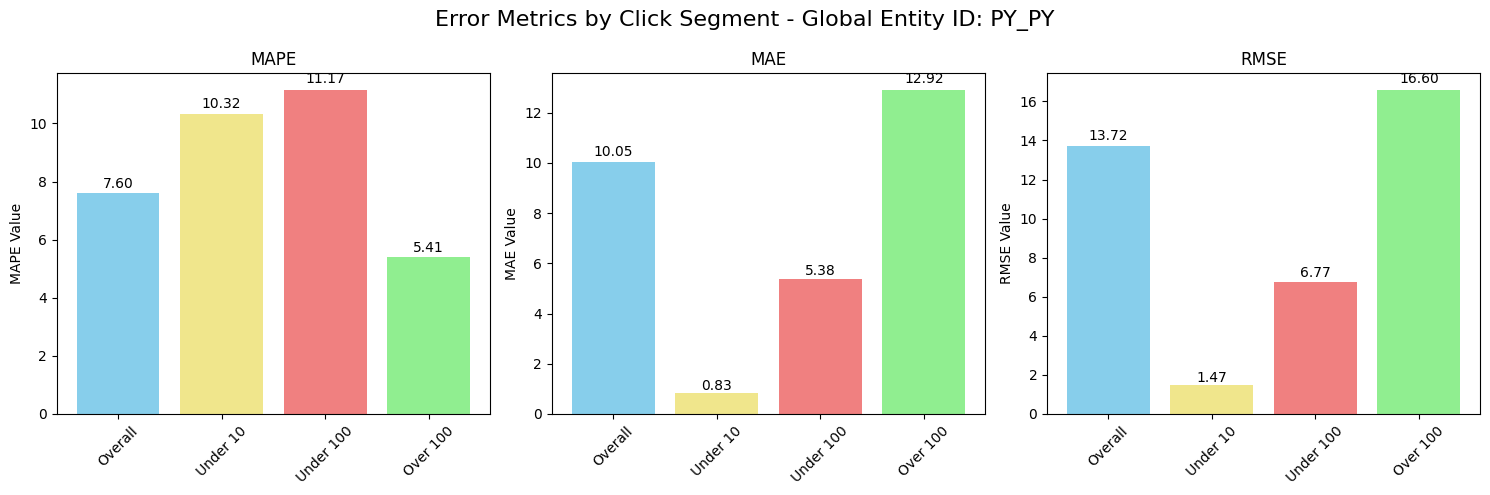

Completed processing for Global Entity ID: PY_PY

Processing Global Entity ID: PY_PE
  Overall:
    MAPE: 6.86%
     MAE: 13.97
    RMSE: 19.99
    Data points: 725
  Under 10:
    MAPE: 23.99%
     MAE: 0.56
    RMSE: 1.13
    Data points: 39
  Under 100:
    MAPE: 14.85%
     MAE: 4.32
    RMSE: 6.39
    Data points: 167
  Over 100:
    MAPE: 4.34%
     MAE: 17.45
    RMSE: 23.08
    Data points: 527


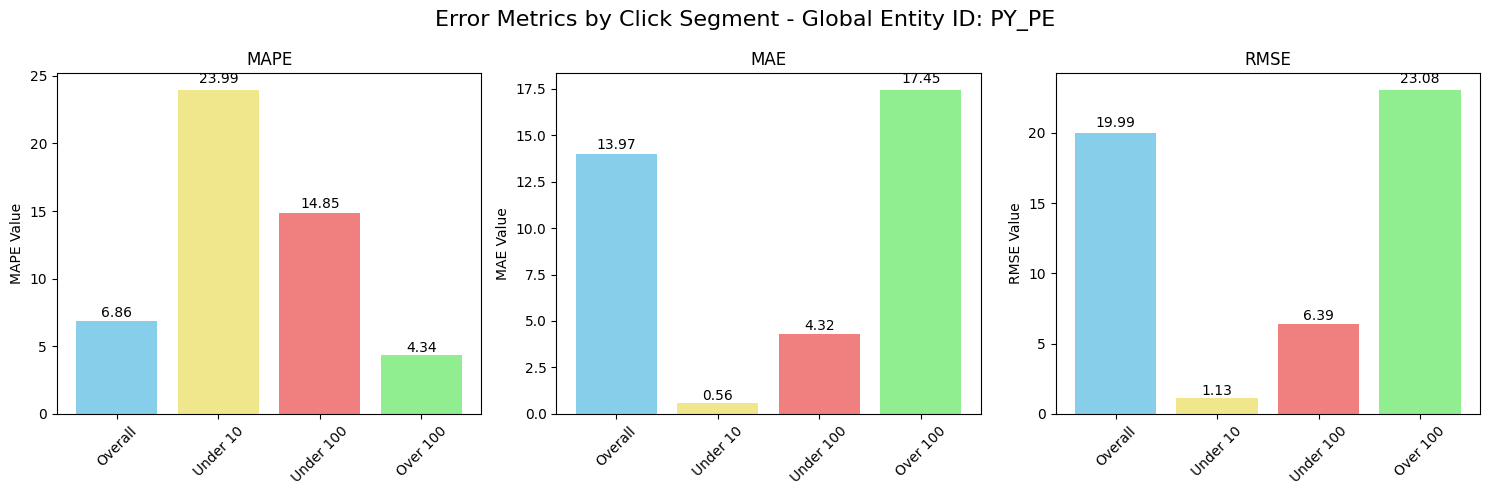

Completed processing for Global Entity ID: PY_PE

Processing Global Entity ID: PY_UY
  Overall:
    MAPE: 6.21%
     MAE: 17.43
    RMSE: 24.91
    Data points: 248
  Under 10:
    MAPE: 6.67%
     MAE: 0.33
    RMSE: 0.58
    Data points: 3
  Under 100:
    MAPE: 18.99%
     MAE: 2.79
    RMSE: 3.53
    Data points: 33
  Over 100:
    MAPE: 4.25%
     MAE: 19.68
    RMSE: 26.72
    Data points: 215


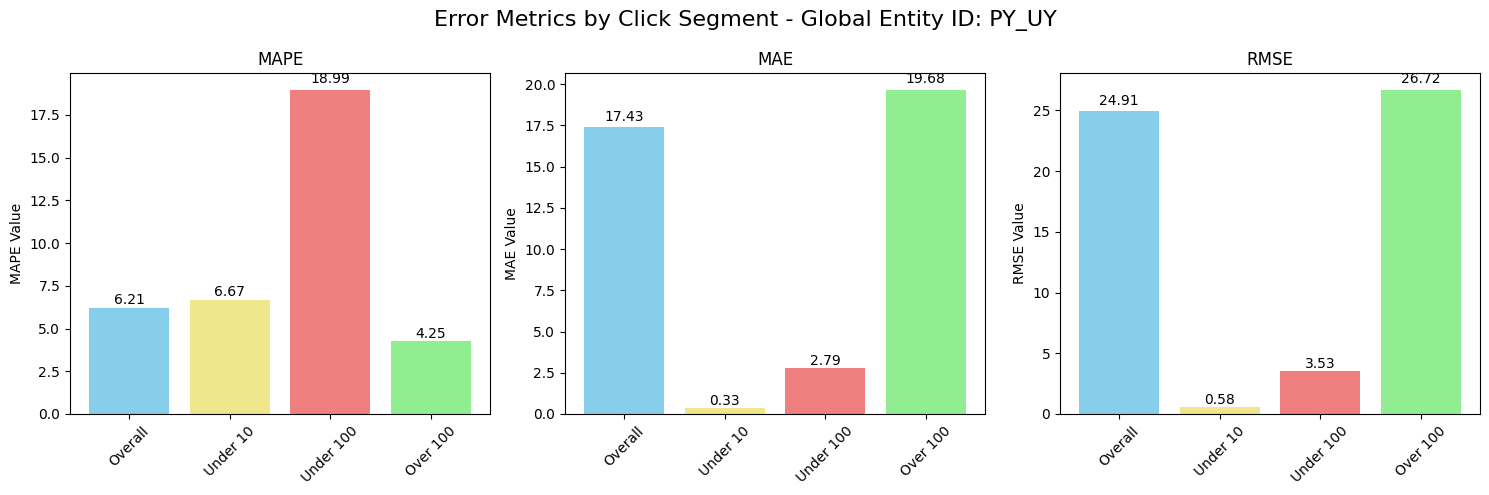

Completed processing for Global Entity ID: PY_UY

Processing Global Entity ID: PY_VE
  Overall:
    MAPE: 8.47%
     MAE: 12.86
    RMSE: 15.87
    Data points: 73
  Under 10:
    MAPE: 50.00%
     MAE: 2.00
    RMSE: 2.00
    Data points: 1
  Under 100:
    MAPE: 13.75%
     MAE: 7.33
    RMSE: 9.14
    Data points: 21
  Over 100:
    MAPE: 6.34%
     MAE: 15.10
    RMSE: 17.88
    Data points: 52


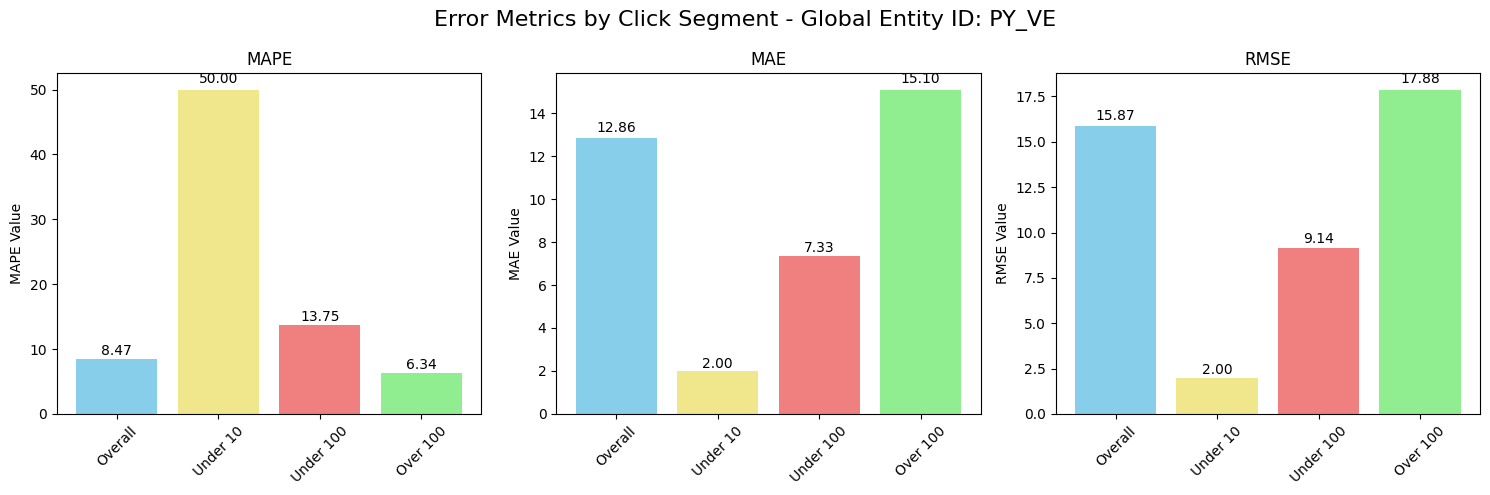

Completed processing for Global Entity ID: PY_VE

Processing Global Entity ID: TB_BH
  Overall:
    MAPE: 5.55%
     MAE: 9.00
    RMSE: 15.22
    Data points: 316
  Under 10:
    MAPE: 3.24%
     MAE: 0.10
    RMSE: 0.53
    Data points: 99
  Under 100:
    MAPE: 6.19%
     MAE: 2.08
    RMSE: 4.10
    Data points: 167
  Over 100:
    MAPE: 4.76%
     MAE: 16.76
    RMSE: 21.77
    Data points: 148


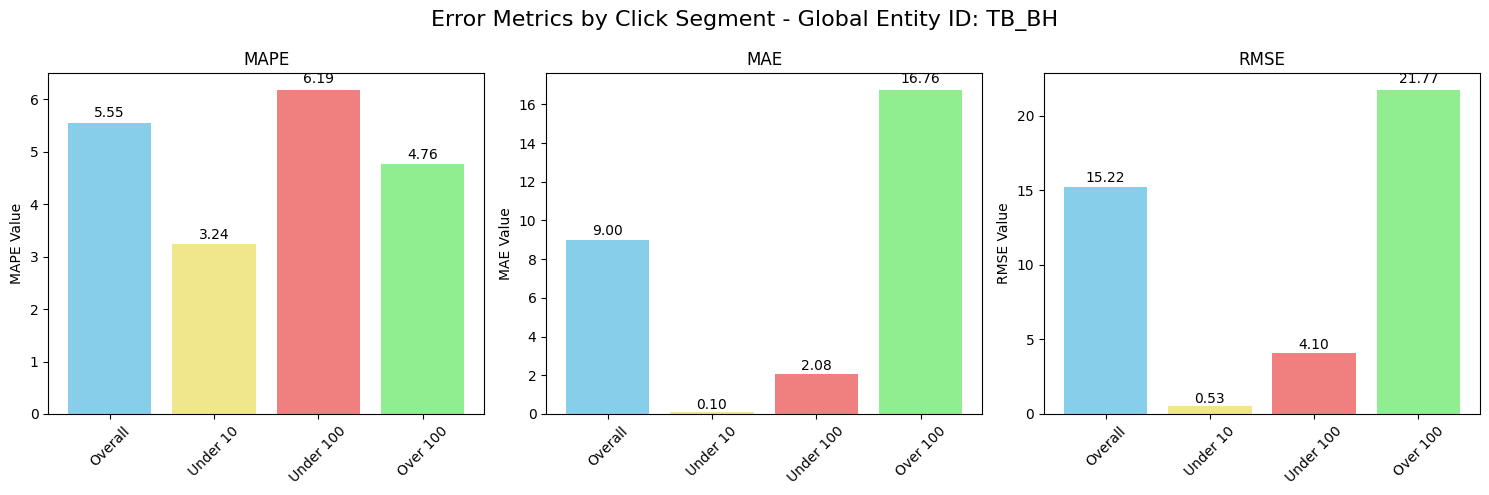

Completed processing for Global Entity ID: TB_BH

Processing Global Entity ID: HF_EG
  Overall:
    MAPE: 3.56%
     MAE: 17.71
    RMSE: 29.41
    Data points: 1585
  Under 10:
    MAPE: 2.81%
     MAE: 0.10
    RMSE: 0.55
    Data points: 403
  Under 100:
    MAPE: 4.85%
     MAE: 0.92
    RMSE: 2.74
    Data points: 476
  Over 100:
    MAPE: 3.01%
     MAE: 24.92
    RMSE: 35.11
    Data points: 1109


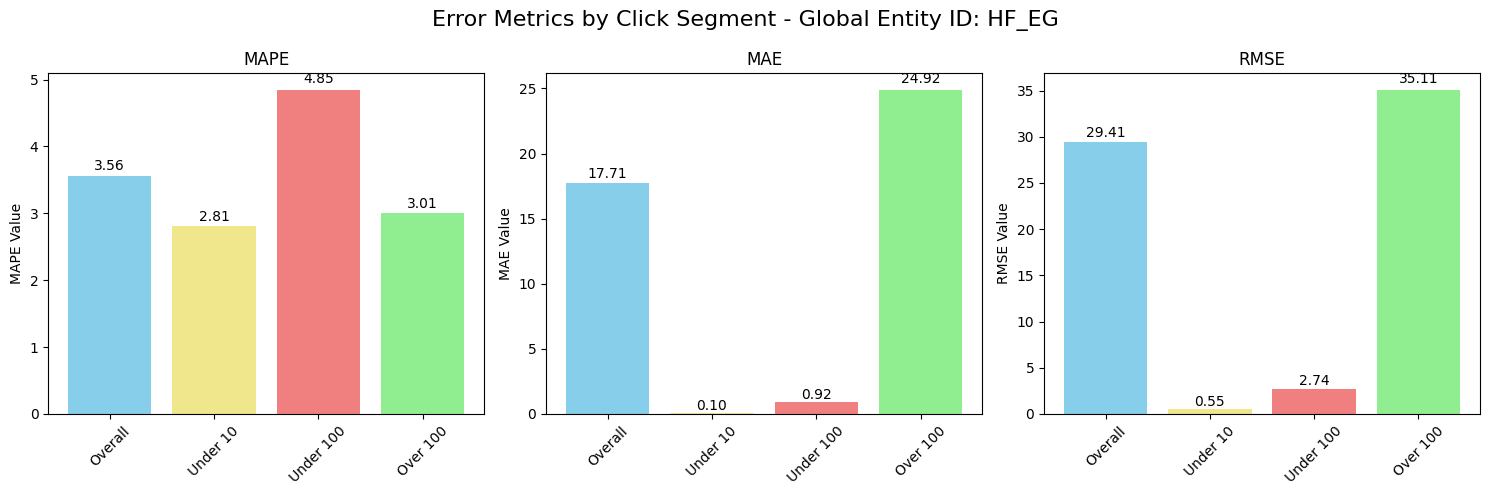

Completed processing for Global Entity ID: HF_EG

Processing Global Entity ID: TB_IQ
  Overall:
    MAPE: 5.41%
     MAE: 13.30
    RMSE: 20.67
    Data points: 932
  Under 10:
    MAPE: 6.28%
     MAE: 0.28
    RMSE: 1.01
    Data points: 183
  Under 100:
    MAPE: 8.03%
     MAE: 1.79
    RMSE: 3.64
    Data points: 267
  Over 100:
    MAPE: 4.34%
     MAE: 18.05
    RMSE: 24.48
    Data points: 658


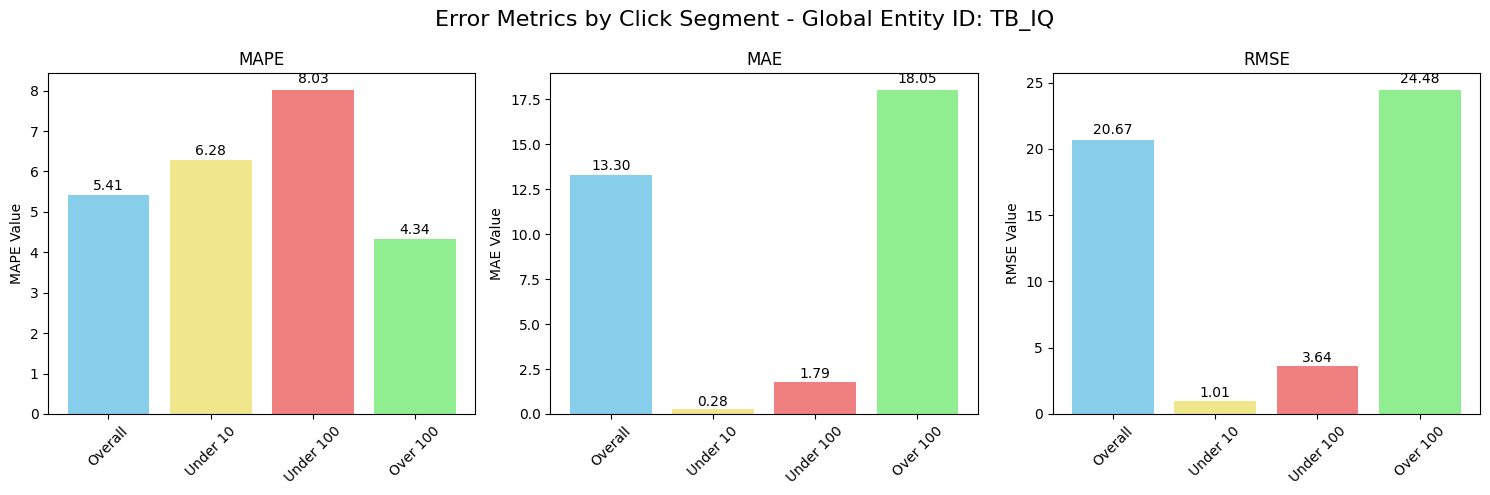

Completed processing for Global Entity ID: TB_IQ

Processing Global Entity ID: TB_JO
  Overall:
    MAPE: 3.57%
     MAE: 12.04
    RMSE: 20.87
    Data points: 869
  Under 10:
    MAPE: 2.21%
     MAE: 0.06
    RMSE: 0.37
    Data points: 348
  Under 100:
    MAPE: 3.15%
     MAE: 0.54
    RMSE: 2.02
    Data points: 387
  Over 100:
    MAPE: 3.91%
     MAE: 21.28
    RMSE: 27.96
    Data points: 482


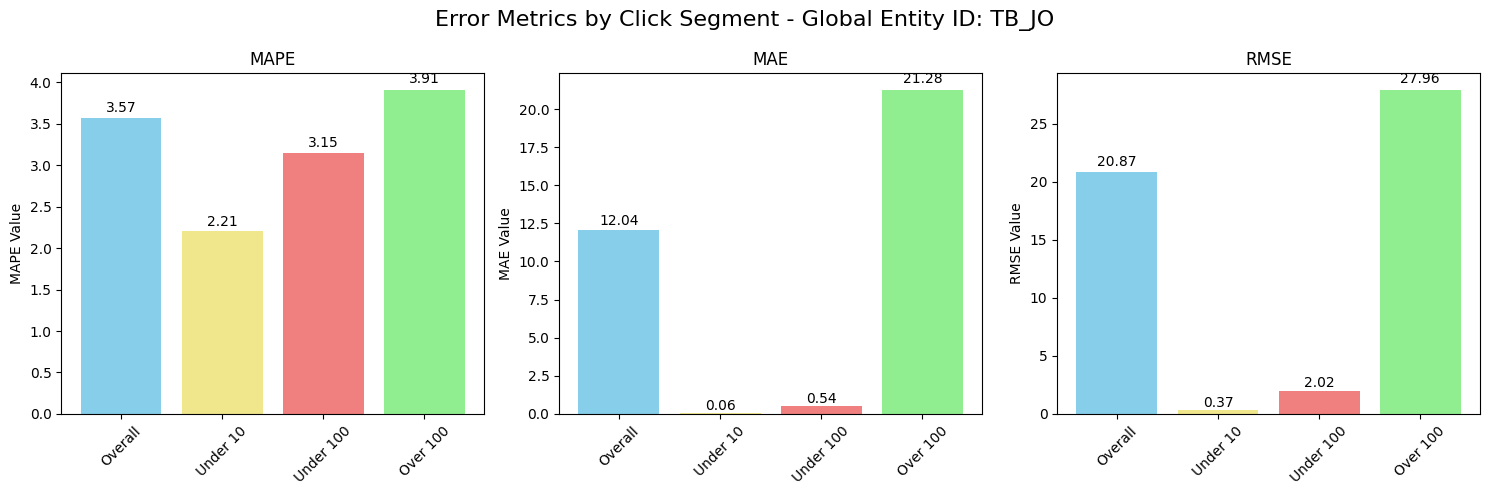

Completed processing for Global Entity ID: TB_JO

Processing Global Entity ID: TB_KW
  Overall:
    MAPE: 3.58%
     MAE: 23.33
    RMSE: 39.21
    Data points: 1479
  Under 10:
    MAPE: 2.73%
     MAE: 0.10
    RMSE: 0.49
    Data points: 284
  Under 100:
    MAPE: 5.61%
     MAE: 1.48
    RMSE: 3.63
    Data points: 371
  Over 100:
    MAPE: 2.90%
     MAE: 30.67
    RMSE: 45.27
    Data points: 1107


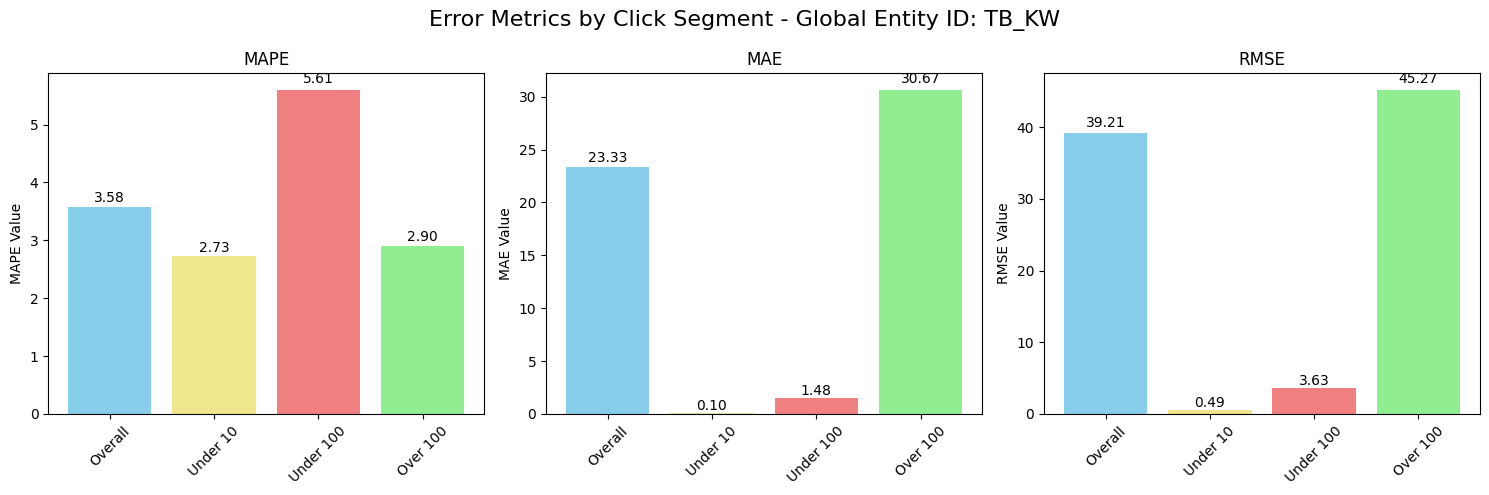

Completed processing for Global Entity ID: TB_KW

Processing Global Entity ID: TB_OM
  Overall:
    MAPE: 2.95%
     MAE: 10.43
    RMSE: 20.10
    Data points: 186
  Under 10:
    MAPE: 2.92%
     MAE: 0.05
    RMSE: 0.34
    Data points: 97
  Under 100:
    MAPE: 3.33%
     MAE: 0.28
    RMSE: 1.26
    Data points: 103
  Over 100:
    MAPE: 2.47%
     MAE: 23.02
    RMSE: 30.05
    Data points: 83


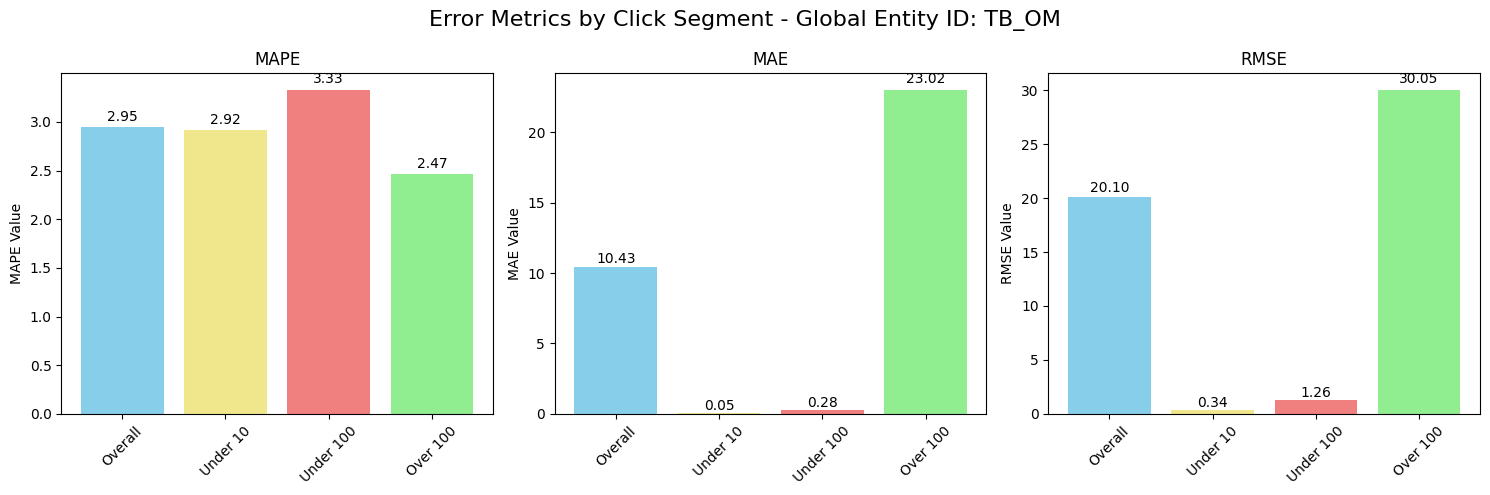

Completed processing for Global Entity ID: TB_OM

Processing Global Entity ID: TB_QA
  Overall:
    MAPE: 4.56%
     MAE: 8.02
    RMSE: 14.15
    Data points: 695
  Under 10:
    MAPE: 1.52%
     MAE: 0.03
    RMSE: 0.22
    Data points: 258
  Under 100:
    MAPE: 3.72%
     MAE: 1.55
    RMSE: 4.11
    Data points: 346
  Over 100:
    MAPE: 5.42%
     MAE: 14.48
    RMSE: 19.57
    Data points: 348


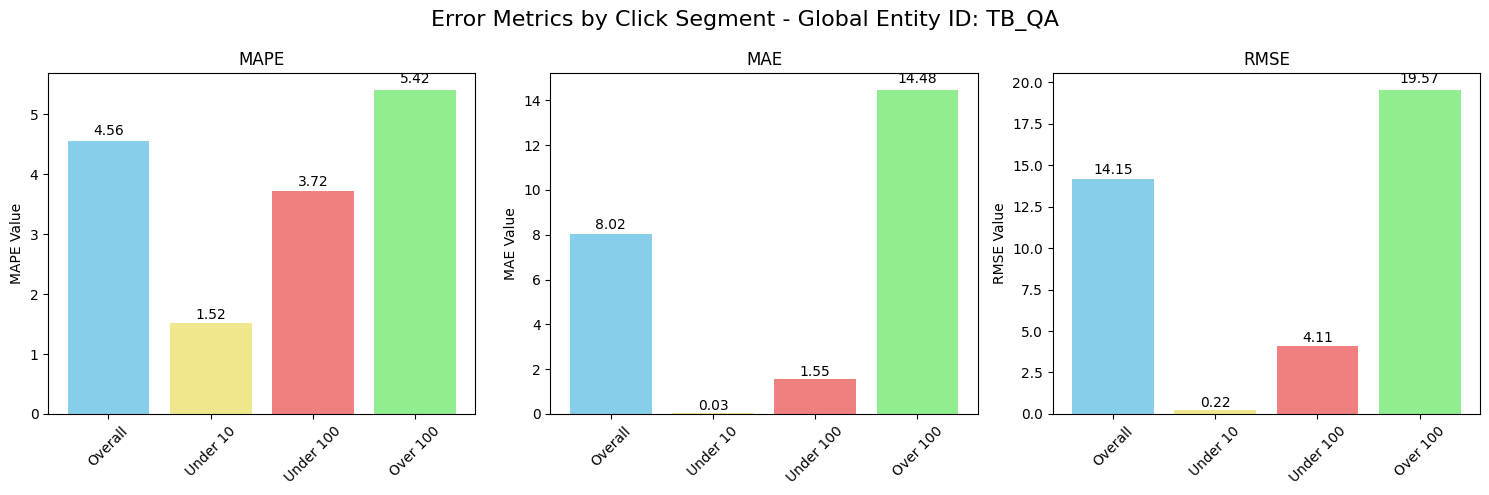

Completed processing for Global Entity ID: TB_QA

Processing Global Entity ID: TB_AE
  Overall:
    MAPE: 5.18%
     MAE: 12.52
    RMSE: 21.17
    Data points: 3728
  Under 10:
    MAPE: 4.66%
     MAE: 0.12
    RMSE: 0.54
    Data points: 887
  Under 100:
    MAPE: 6.68%
     MAE: 1.96
    RMSE: 4.36
    Data points: 1316
  Over 100:
    MAPE: 4.35%
     MAE: 18.32
    RMSE: 26.17
    Data points: 2403


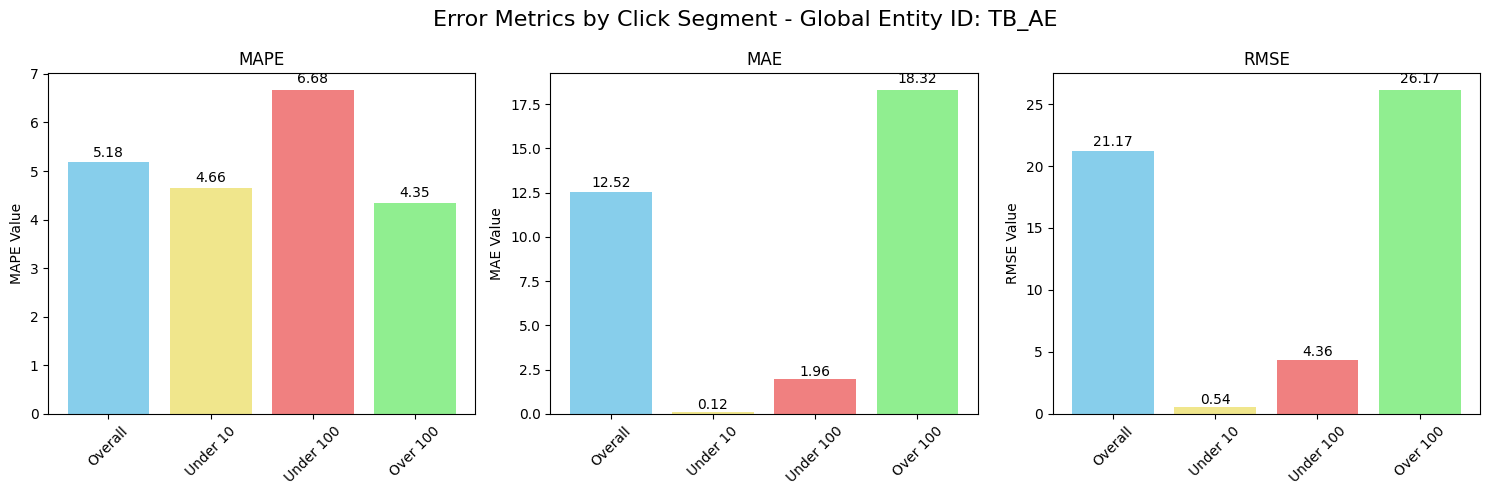

Completed processing for Global Entity ID: TB_AE

Processing Global Entity ID: YS_TR
  Overall:
    MAPE: 3.68%
     MAE: 27.37
    RMSE: 38.87
    Data points: 1824
  Under 10:
    MAPE: 21.42%
     MAE: 0.39
    RMSE: 1.03
    Data points: 57
  Under 100:
    MAPE: 15.50%
     MAE: 3.07
    RMSE: 5.18
    Data points: 120
  Over 100:
    MAPE: 2.84%
     MAE: 29.11
    RMSE: 40.22
    Data points: 1702


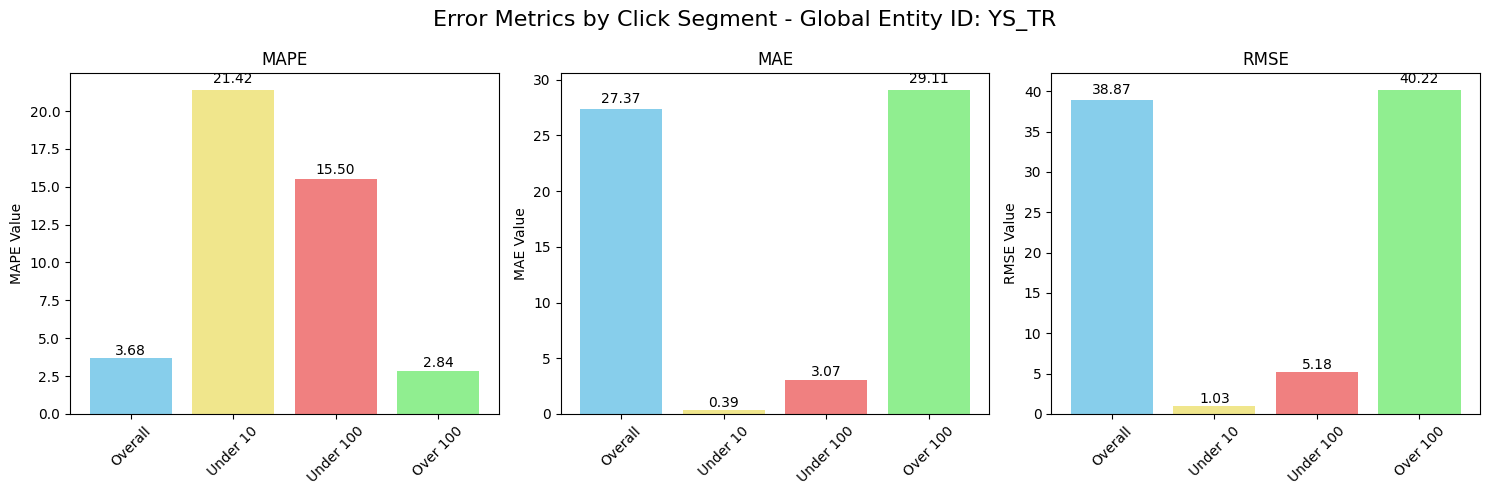

Completed processing for Global Entity ID: YS_TR

Processing Global Entity ID: EF_GR
  Overall:
    MAPE: 5.97%
     MAE: 10.96
    RMSE: 16.61
    Data points: 51
  Under 10:
    MAPE: 4.23%
     MAE: 0.33
    RMSE: 0.58
    Data points: 6
  Under 100:
    MAPE: 6.94%
     MAE: 2.42
    RMSE: 3.92
    Data points: 19
  Over 100:
    MAPE: 5.39%
     MAE: 16.03
    RMSE: 20.74
    Data points: 32


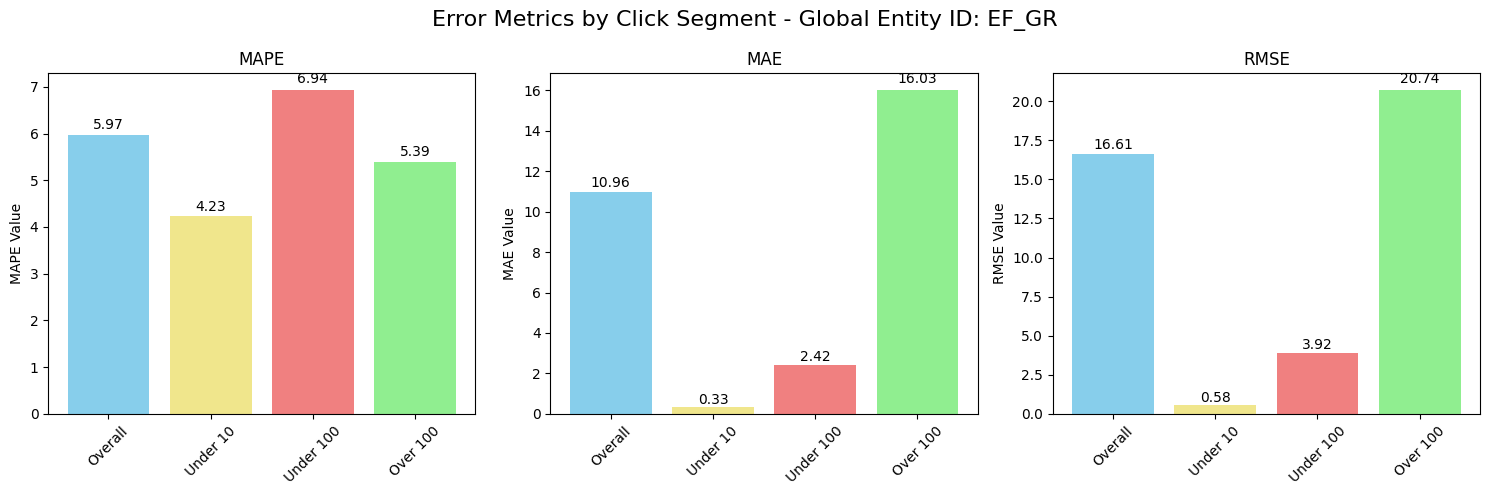

Completed processing for Global Entity ID: EF_GR

Processing Global Entity ID: GV_KZ
  Overall:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 3
  Under 10:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 3
  Under 100:
    MAPE: 0.00%
     MAE: 0.00
    RMSE: 0.00
    Data points: 3
  Over 100: No data points


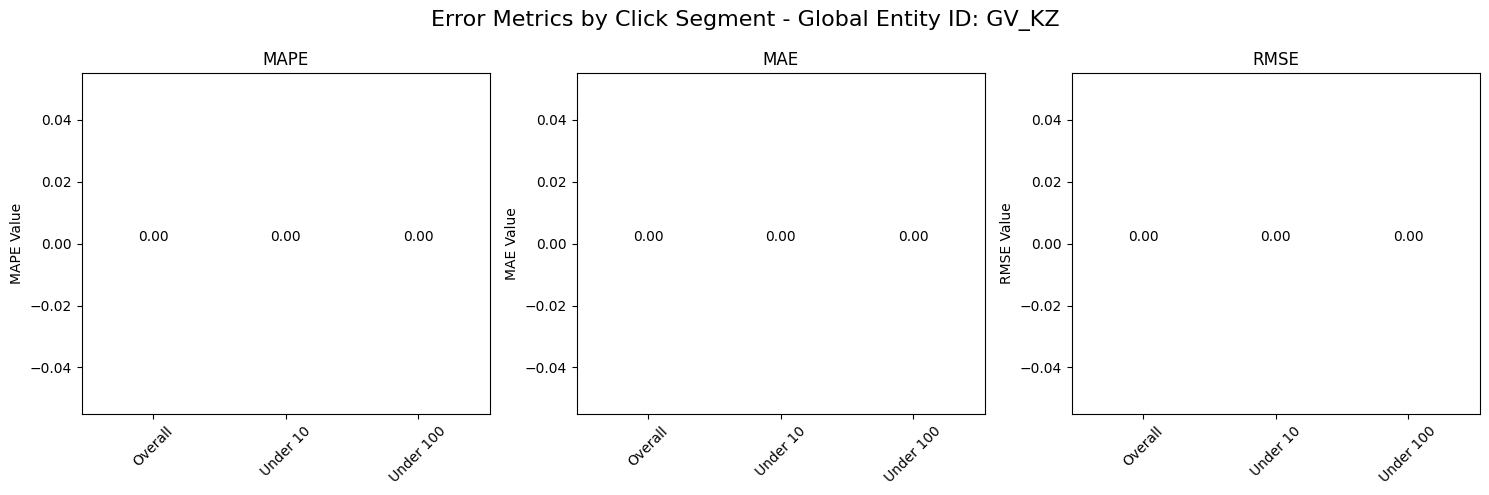

Completed processing for Global Entity ID: GV_KZ

Processing Global Entity ID: GV_AM
  Overall:
    MAPE: 100.00%
     MAE: 2.00
    RMSE: 2.00
    Data points: 1
  Under 10:
    MAPE: 100.00%
     MAE: 2.00
    RMSE: 2.00
    Data points: 1
  Under 100:
    MAPE: 100.00%
     MAE: 2.00
    RMSE: 2.00
    Data points: 1
  Over 100: No data points


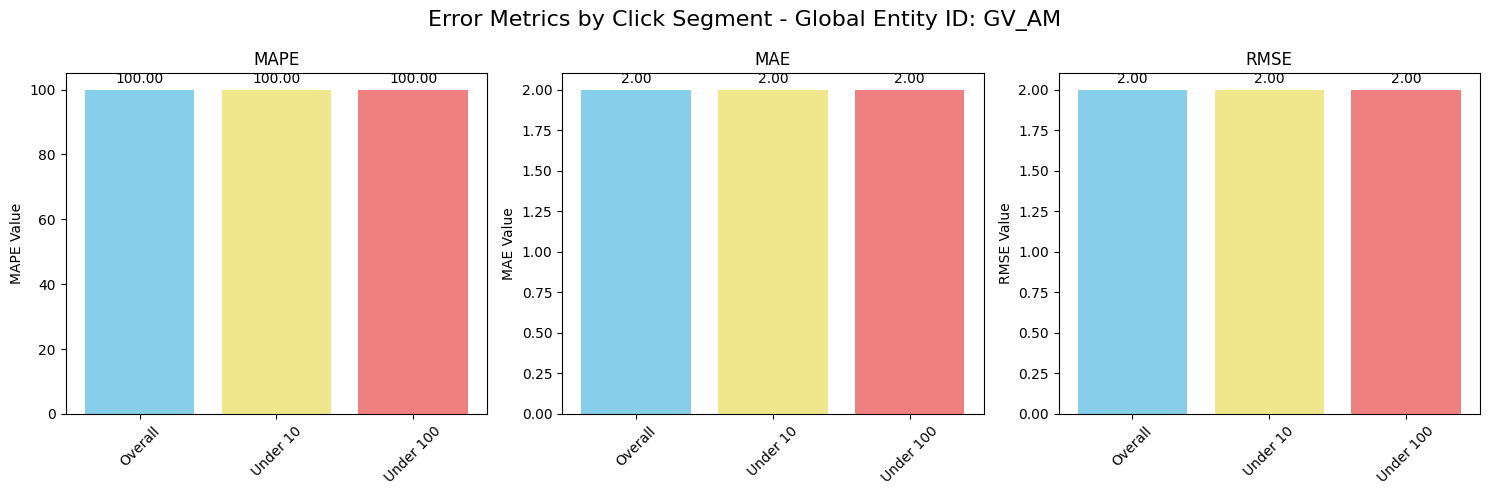

Completed processing for Global Entity ID: GV_AM


In [64]:
for entity_id in df['global_entity_id'].unique():
    print(f"\n{'='*50}")
    print(f"Processing Global Entity ID: {entity_id}")
    print(f"{'='*50}")
    
    # Filter data for this entity
    entity_df = df.loc[df['global_entity_id'] == entity_id]
    
    # Extract clicks data
    actual_clicks = entity_df.cpc_clicks.values 
    sample_realisations = np.array(rng.poisson(actual_clicks))
    assert len(actual_clicks) == len(sample_realisations), "The lengths aren't the same, you've messed something up"

    # Create segments
    i_under_10_actual = np.argwhere(actual_clicks < 10).flatten()
    actual_clicks_under_10 = actual_clicks[i_under_10_actual]
    sample_actual_under_10 = sample_realisations[i_under_10_actual]
    
    i_over_10_actual = np.argwhere(actual_clicks > 10).flatten()
    actual_clicks_over_10 = actual_clicks[i_over_10_actual]
    sample_actual_over_10 = sample_realisations[i_over_10_actual]
    
    i_under_100_actual = np.argwhere(actual_clicks < 100).flatten()
    actual_clicks_under_100 = actual_clicks[i_under_100_actual]
    sample_actual_under_100 = sample_realisations[i_under_100_actual]
    
    i_over_100_actual = np.argwhere(actual_clicks > 100).flatten()
    actual_clicks_over_100 = actual_clicks[i_over_100_actual]
    sample_actual_over_100 = sample_realisations[i_over_100_actual]
    
    # Calculate metrics for all segments
    segments = {
        'Overall': (actual_clicks, sample_realisations),
        'Under 10': (actual_clicks_under_10, sample_actual_under_10),
        'Under 100': (actual_clicks_under_100, sample_actual_under_100),
        'Over 100': (actual_clicks_over_100, sample_actual_over_100)
    }
    
    results = {}
    
    for segment_name, (actual, predicted) in segments.items():
        # Skip empty segments
        if len(actual) == 0:
            print(f"  {segment_name}: No data points")
            continue
            
        # Calculate all metrics
        mape = mean_absolute_percentage_error(actual, predicted)
        rmse = root_mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        
        results[segment_name] = {
            'MAPE': mape * 100,  # Convert to percentage
            'RMSE': rmse,
            'MAE': mae
        }
        
        # Print results
        print(f"  {segment_name}:")
        print(f"    MAPE: {mape * 100:.2f}%")
        print(f"     MAE: {mae:.2f}")
        print(f"    RMSE: {rmse:.2f}")
        print(f"    Data points: {len(actual)}")

    # Create bar chart for specific segments (only if we have data)
    chart_segments = [seg for seg in ['Overall', 'Under 10', 'Under 100', 'Over 100'] if seg in results]
    
    if len(chart_segments) > 0:
        metrics = ['MAPE', 'MAE', 'RMSE']
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Error Metrics by Click Segment - Global Entity ID: {entity_id}', fontsize=16)
        
        for i, metric in enumerate(metrics):
            values = [results[segment][metric] for segment in chart_segments]
            
            bars = axes[i].bar(chart_segments, values, color=['skyblue', 'khaki', 'lightcoral', 'lightgreen'][:len(chart_segments)])
            axes[i].set_title(f'{metric}')
            axes[i].set_ylabel(f'{metric} Value')
            axes[i].tick_params(axis='x', rotation=45)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
                            f'{value:.2f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(BASE_PLOT_PATH / f"benchmark_rmse_mape_entity_{entity_id}.png", dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print(f"  No valid segments found for entity {entity_id} - skipping plot")
    
    print(f"Completed processing for Global Entity ID: {entity_id}")